# Mod 4 Project - Time Series Predictions


## Import Libraries and initial settings

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib.pylab import rcParams
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_process import arma_generate_sample
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import itertools


# import folium
# from ast import literal_eval
import warnings
warnings.filterwarnings("ignore")
import pmdarima as pm
from pmdarima.arima import auto_arima


In [30]:
#Define Pandas display options for inspection 
# Set max rows to display to 2000
pd.set_option('display.max_rows', 2000)
# Set max columns to display to 500
pd.set_option('display.max_columns', 500)

## User defined functions

In [31]:
#This function is used to address stationarity per zipcode

def stationarityTest(ts, wd = 4):
    
    #ts is the time series with time as index and target variable
    #wd is the window for the rolling statistics test
    #zipcode is the zipcode under analysis
    
    rolmean = ts.rolling(window = wd, center = False).mean()
    rolstd = ts.rolling(window = wd, center = False).std()
    fig = plt.figure(figsize = (8, 4))
    orig = plt.plot(ts, color ='blue', label = 'Original')
    mean = plt.plot(rolmean, color ='red', label ='Rolling Mean')
    std = plt.plot(rolstd, color ='black', label ='Rolling Std')
    plt.legend(loc ='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Dikie Fuller test only accepts 1d series, therefore we pass the values column only
    dftest = adfuller(ts['value'])
    dfoutput = pd.Series(dftest[0:4], index =['Test Statistic',
                                             'p-value',
                                             '#Lags Used',
                                             'Number of observation'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value(%s)'%key] = value
    return(dfoutput)

In [32]:
def train_test_split(data):
    
    n = len(data['value'])
    training_n = int(n*0.8)
    
    for i in range(0, len(data)):
    #Split datasets into training and testing
        train_df = data.iloc[:training_n]
        test_df = data.iloc[training_n:]
    
    return train_df, test_df

In [33]:
def tsrollingmean(ts,wd = 2):
    rolmean = ts.rolling(window = wd).mean()
    data_minus_rolmean = ts - rolmean
    data_minus_rolmean.dropna(inplace=True)
    return(data_minus_rolmean)

In [34]:
# Plot the autocorrelation and partial autocorrelation functions for a given dataset and number of lags
def check_autocorrelation(df, lags, col):
    plot_acf(df, lags=lags, ax=ax[0][col])
    plot_pacf(df, lags=lags, ax=ax[1][col])

In [375]:
#Francis updated
def ARIMA_modeling(timeSeries):
    '1. Take time series and use the seasonal decompose to check seasonality and trending on the ts '
    '2. Calculate the optimal ARIMA parameters using pmdarima.auto_arima'
    '3. Create ARIMA model on training data using statsmodels ARIMA'
    '4. Plot training, test and forecasted data'
    
    AIC_list = []
    rmse_list = []
    for i,ts in enumerate(timeSeries): 
        decomposition = seasonal_decompose(ts)

        # Gather the trend, seasonality and noise of decomposed object
        trend = decomposition.trend
        seasonal = decomposition.seasonal
        residual = decomposition.resid
        residuals_list.append(residual)
        residual.dropna(inplace=True) #for adfuller ts needs to be free of NaNs and 
        #ts['res'] = residual

        # Plot gathered statistics
        plt.figure(figsize=(5,5))
        plt.subplot(411)
        plt.plot(ts, label='Original', color='green',alpha=0.4)
        plt.legend(loc='best')
        plt.subplot(412)
        plt.plot(trend, label='Trend', color='green',alpha=0.4)
        plt.legend(loc='best')
        plt.subplot(413)
        plt.plot(seasonal,label='Seasonality', color='green',alpha=0.4)
        plt.legend(loc='best')
        plt.subplot(414)
        plt.plot(residual, label='Residuals', color='green',alpha=0.4)
        plt.legend(loc='best')
        plt.tight_layout()
 
        adfuller1D = residual.iloc[:,0].values #you need to make it a 1d series
        result = adfuller(adfuller1D)
        print('City: ', i)
        print('ADF Statistic Residual: %f' % result[0])
        print('p-value: %f' % result[1])

        plt.show()

        # I will create my model on the train data and then plot test along the forecasted data to 
        #visually confirm the accuracy of my forecasted data. 

        #using 24 since 121 - (121*0.80) = 24 -- 121 is the total number of observations in my dataset
        #adjust appropriately
        train = ts[:-24]  
        test = ts[-24:]

        #Will ise pmdarima.auto_arima to get the optimal model order
        model = pm.auto_arima(train.value.dropna(), start_p=1, start_q=1,
                          test='adf',       # use adftest to find optimal 'd'
                          max_p=5, max_q=5, # maximum p and q -- got this from ACF & PACF
                          m=1,              # frequency of series
                          d=None,           # let model determine 'd'
                          seasonal=False,   # No Seasonality
                          start_P=0, 
                          D=0, 
                          trace=True,
                          error_action='ignore',  
                          suppress_warnings=True, 
                          stepwise=True)

        print(model.summary())
        model.plot_diagnostics(figsize=(8, 8))
        plt.show()

        #####Forecast###
        test_index = test.index[:]
        model2 = ARIMA(train.value, order=model.order)
        fitted = model2.fit(disp=-1) 
        
        #Collect AIC to compare
        AIC_list.append(fitted.aic)

        # Forecast
        fc, se, conf = fitted.forecast(48, alpha=0.05)  # 95% conf
        index_of_fc = pd.date_range(ts.index[-24], periods=48, freq='M')

        # Make as pandas series
        fc_series = pd.Series(fc, index=index_of_fc)
        #Capture the confidence intervals of the forecast
        lower_series = pd.Series(conf[:, 0], index=index_of_fc)
        upper_series = pd.Series(conf[:, 1], index=index_of_fc)

        
        #RMSE
        rmse = np.sqrt(mean_squared_error(test.iloc[:,0], fc_series[:-24]))
        percentage = rmse/ts.mean()*100
        rmse_list.append(percentage)

        print('The Root Mean Squared Error of our forcast is {}'.format(round(rmse, 2)))
        print('The root mean squared error of City: {}'.format(i)
              + ' of our forcast is{}% of mean housing price from 2019.'.format(round(percentage,3)))
        
        # Plot
        plt.figure(figsize=(8,4), dpi=100)
        plt.plot(train.value, label='training')
        plt.plot(test.value, label='actual')
        plt.plot(fc_series, label='forecast')
        plt.fill_between(lower_series.index, lower_series, upper_series, 
                         color='k', alpha=.15)
        plt.title('Forecast vs Actuals')
        plt.legend(loc='upper left', fontsize=8)
        plt.show()
        
    return(print('AIC list: {}'.format(AIC_list)), print('RMSE list: {}'.format(rmse_list)))

In [389]:
#Francis updated 
# Identify optimal order of SARIMAX function.  p, d, and q represent maximum values
def optimise_sarimax(df, p, d, q):
    
    'This functions output is to be used in SARIMA_modeling'
    'Output: dataframe with sorted AIC for specific pdq, pdqs combinations'
    
    # Create a list with all possible values for p, d and q up to specified maximum
    p = list(range(0,p))
    d = list(range(0,d))
    q = list(range(0,q))

    # Generate all different combinations of p, q and q triplets
    pdq = list(itertools.product(p, d, q))

    # Generate all different combinations of seasonal p, q and q triplets (use 12 for frequency given annual cyclicality)
    pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
    
    # Create dataframe that displays order v. AIC criterion.  Order with lowest AIC selected
    results = []

    for i in range(0, len(pdqs)):
        model = sm.tsa.statespace.SARIMAX(endog=df, order = pdq[i], seasonal_order = pdqs[i], enforce_stationarity = False, enforce_invertibility = False, freq='MS')
        result = model.fit(maxiter=200)
        results.append({'pdq': f"{pdq[i]}", 'pdqs': f"{pdqs[i]}", 'AIC':result.aic})
    
    results_df = pd.DataFrame(results)
    results_df.sort_values(by=['AIC'], ascending = True, inplace=True)
    results_df.reset_index(inplace=True)
    
    return results_df 

In [387]:
def SARIMA_modeling(timeSeries, ARIMA_optimal_order, SARIMA_optimal_order):    
    
    'This function is the step#2 for the SARIMA modeling'
    'ARIMA and SARIMA optimal order should be passed in the form of list of tuples'
    'List of Optimal orders is obtained from optimise_sarimax function'
    
    AIC_list = []
    rmse_list = []
    for i in range(0, len(timeSeries)):
        series = timeSeries[i]

        train = series[:-24]  
        test = series[-24:]

        #Create the model on train data
        SARIMAX_MODEL = sm.tsa.statespace.SARIMAX(train,
                                        order=eval(ARIMA_optimal_order[i]),
                                        seasonal_order= eval(SARIMA_optimal_order[i]),
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)
        # Fit the model and print results
        fitted = SARIMAX_MODEL.fit()

        print('City:',[i])
        print('Non-seasonal parameters (p,d,q):', ARIMA_optimal_order[i])
        print('Seasonal parameters and periodicity (P,D,Q,s):', SARIMA_optimal_order[i])
        print('AIC:', fitted.aic)
        print('BIC:', fitted.bic)
        print(fitted.summary().tables[1])
        fitted.plot_diagnostics(figsize=(8,6))
        plt.show()
    #     outputs.append(output)
        print('\n')

        #Collect AIC to compare
        AIC_list.append(fitted.aic)

        # Forecast from SARIMAX results
        fc = fitted.forecast(48)
        conf = fitted.conf_int(alpha=0.05)
        index_of_fc = pd.date_range(series.index[-24], periods=48, freq='M')

        fc_series = pd.Series(fc)
        #Capture the confidence intervals of the forecast
    #     lower_series = pd.Series(conf.iloc[:,0], index=index_of_fc)
    #     upper_series = pd.Series(conf.iloc[:,1], index=index_of_fc)

        #Compute MSE
        rmse = np.sqrt(((fc_series[:-24]-test.iloc[:,0])**2).mean())
        percentage = rmse/series.mean()*100
        rmse_list.append(percentage)

        print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))
        print('The root mean squared error of City: {}'.format(i)
              + ' of our forcast is '
              +'{}% of mean housing price from 2017.'.format(round(percentage,3)))


         # Plot
        plt.figure(figsize=(8,4), dpi=100)
        plt.plot(train.value, label='training')
        plt.plot(test.value, label='actual')
        plt.plot(fc_series, label='forecast')
    #     plt.fill_between(lower_series.index, lower_series, upper_series, 
    #                          color='k', alpha=.15)
        plt.title('Forecast vs Actuals')
        plt.legend(loc='upper left', fontsize=8)
        plt.show()

    return(print('AIC list: {}'.format(AIC_list)), print('RMSE list: {}'.format(rmse_list)))

# EDA

In [37]:
#Load updated data
df = pd.read_csv('UpdatedZillow.csv', encoding='latin-1')
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,1999-11,1999-12,2000-01,2000-02,2000-03,2000-04,2000-05,2000-06,2000-07,2000-08,2000-09,2000-10,2000-11,2000-12,2001-01,2001-02,2001-03,2001-04,2001-05,2001-06,2001-07,2001-08,2001-09,2001-10,2001-11,2001-12,2002-01,2002-02,2002-03,2002-04,2002-05,2002-06,2002-07,2002-08,2002-09,2002-10,2002-11,2002-12,2003-01,2003-02,2003-03,2003-04,2003-05,2003-06,2003-07,2003-08,2003-09,2003-10,2003-11,2003-12,2004-01,2004-02,2004-03,2004-04,2004-05,2004-06,2004-07,2004-08,2004-09,2004-10,2004-11,2004-12,2005-01,2005-02,2005-03,2005-04,2005-05,2005-06,2005-07,2005-08,2005-09,2005-10,2005-11,2005-12,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09
0,61639,10025,New York,NY,New York-Newark-Jersey City,New York County,1,168300.0,168400.0,168400.0,168400.0,168400.0,168600.0,169200.0,170000.0,171500.0,173300.0,175100.0,176900.0,178600.0,180100.0,181500.0,182700.0,183800.0,184900.0,186300.0,188000.0,190100.0,192700.0,195500.0,198400.0,201500.0,204700.0,208100.0,211500.0,215100.0,218800.0,222700.0,226700.0,231100.0,235800.0,240600.0,245400.0,250600.0,255900.0,261300.0,267200.0,273600.0,280500.0,288100.0,296300.0,305100.0,314300.0,323500.0,332200.0,340600.0,348300.0,355100.0,361300.0,367200.0,372800.0,378400.0,384100.0,389900.0,395800.0,401600.0,406900.0,411500.0,415200.0,417800.0,419400.0,420400.0,421000.0,421300.0,421200.0,420500.0,419700.0,418900.0,417900.0,416400.0,414800.0,413100.0,411700.0,411000.0,411500.0,412800.0,415400.0,419000.0,422800.0,426900.0,432400.0,440700.0,453100.0,470400.0,491100.0,511600.0,528400.0,540300.0,547700.0,551700.0,554200.0,556400.0,558700.0,561300.0,564100.0,567500.0,572500.0,579600.0,589000.0,599600.0,610200.0,621600.0,634500.0,648800.0,663800.0,678200.0,690900.0,701600.0,710300.0,717600.0,724100.0,730700.0,737400.0,744200.0,751400.0,758400.0,764700.0,769900.0,773600.0,774900.0,772600.0,767200.0,761800.0,760300.0,763700.0,770500.0,778000.0,785000.0,791100.0,795800.0,799300.0,803200.0,809500.0,819400.0,831500.0,843200.0,851900.0,856000.0,856900.0,856100.0,852800.0,845800.0,836100.0,825900.0,820200.0,820800.0,822900.0,822100.0,818500.0,812600.0,807300.0,804600.0,803100.0,801200.0,800200.0,795500.0,783100.0,766900.0,753100.0,743800.0,738500.0,739400.0,740800.0,738600.0,736900.0,744400.0,758600.0,775100.0,789000.0,792600.0,784900.0,777200.0,777000.0,775900.0,772000.0,767600.0,763

In [ ]:
# Load the dataset
df = pd.read_csv('zillow_data.csv')
df.head()

In [38]:
#Check the number of columns in dataframe
len(df.columns)

289

North West Arkansas (NWA) is home of the Walmart Headquarters. 
Washigton and Benton County are growing rapidly as the new Walmart campus was announced to be openened on 2025.

In [39]:
#Select State of AR only
dfAR = df.loc[df['State'] == 'AR']

In [40]:
dfAR.head(2)

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,1999-11,1999-12,2000-01,2000-02,2000-03,2000-04,2000-05,2000-06,2000-07,2000-08,2000-09,2000-10,2000-11,2000-12,2001-01,2001-02,2001-03,2001-04,2001-05,2001-06,2001-07,2001-08,2001-09,2001-10,2001-11,2001-12,2002-01,2002-02,2002-03,2002-04,2002-05,2002-06,2002-07,2002-08,2002-09,2002-10,2002-11,2002-12,2003-01,2003-02,2003-03,2003-04,2003-05,2003-06,2003-07,2003-08,2003-09,2003-10,2003-11,2003-12,2004-01,2004-02,2004-03,2004-04,2004-05,2004-06,2004-07,2004-08,2004-09,2004-10,2004-11,2004-12,2005-01,2005-02,2005-03,2005-04,2005-05,2005-06,2005-07,2005-08,2005-09,2005-10,2005-11,2005-12,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09
309,89249,71913,Hot Springs,AR,Hot Springs,Garland County,310,81600.0,81700.0,81700.0,81700.0,81600.0,81400.0,81300.0,81100.0,81000.0,80800.0,80700.0,80600.0,80800.0,81200.0,81800.0,82600.0,83400.0,84300.0,85100.0,85800.0,86500.0,87200.0,87800.0,88200.0,88600.0,89000.0,89200.0,89300.0,89300.0,89200.0,89100.0,88900.0,88800.0,88700.0,88600.0,88400.0,88300.0,88200.0,88100.0,88200.0,88400.0,88800.0,89200.0,89700.0,90400.0,91100.0,91800.0,92400.0,92800.0,93200.0,93500.0,93700.0,93900.0,94100.0,94300.0,94600.0,94900.0,95300.0,95700.0,96000.0,96200.0,96300.0,96300.0,96300.0,96300.0,96300.0,96400.0,96600.0,96900.0,97200.0,97500.0,97800.0,98000.0,98200.0,98300.0,98600.0,98900.0,99400.0,100000.0,100800.0,101800.0,102900.0,104100.0,105200.0,106400.0,107500.0,108600.0,109600.0,110700.0,111500.0,112200.0,112800.0,113300.0,113800.0,114300.0,114900.0,115700.0,116600.0,117500.0,118400.0,119300.0,120200.0,120900.0,121600.0,122100.0,122600.0,123200.0,124100.0,125200.0,126500.0,127900.0,129500.0,131000.0,132500.0,133800.0,134900.0,135800.0,136500.0,137200.0,137800.0,138300.0,138700.0,139200.0,139700.0,140300.0,141200.0,142000.0,142700.0,143300.0,143800.0,144000.0,143800.0,143400.0,143100.0,142900.0,142700.0,142500.0,142100.0,141600.0,141000.0,140500.0,140000.0,139900.0,139700.0,139600.0,139700.0,139900.0,140000.0,139700.0,139400.0,139000.0,138700.0,138300.0,138000.0,137900.0,137700.0,137200.0,136900.0,136700.0,136400.0,136300.0,136500.0,137000.0,137400.0,138200.0,138800.0,138700.0,138900.0,139800.0,139700.0,138900.0,138300.0,137500.0,136500.0,135600.0,135200.0,135100.0,135300.0,135600.0,136200.0,136500.0,136300.0,135600.0,134600.0,133500.0,133000.0,132600.0,131900.0,131400.0,1

In [41]:
#Select Washington and Benton Countys from AR
dfARCounty = dfAR.loc[dfAR['CountyName'].isin(['Washington County', 'Benton County'])]

In [42]:
dfARCounty.head(2)

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,1999-11,1999-12,2000-01,2000-02,2000-03,2000-04,2000-05,2000-06,2000-07,2000-08,2000-09,2000-10,2000-11,2000-12,2001-01,2001-02,2001-03,2001-04,2001-05,2001-06,2001-07,2001-08,2001-09,2001-10,2001-11,2001-12,2002-01,2002-02,2002-03,2002-04,2002-05,2002-06,2002-07,2002-08,2002-09,2002-10,2002-11,2002-12,2003-01,2003-02,2003-03,2003-04,2003-05,2003-06,2003-07,2003-08,2003-09,2003-10,2003-11,2003-12,2004-01,2004-02,2004-03,2004-04,2004-05,2004-06,2004-07,2004-08,2004-09,2004-10,2004-11,2004-12,2005-01,2005-02,2005-03,2005-04,2005-05,2005-06,2005-07,2005-08,2005-09,2005-10,2005-11,2005-12,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09
808,89707,72701,Fayetteville,AR,Fayetteville-Springdale-Rogers,Washington County,809,83100.0,83400.0,83500.0,83500.0,83400.0,83400.0,83300.0,83200.0,83100.0,83400.0,83900.0,84500.0,85000.0,85400.0,85500.0,85700.0,85700.0,85700.0,85700.0,85700.0,85700.0,85900.0,86400.0,86900.0,87200.0,87200.0,87200.0,87100.0,87000.0,87000.0,87100.0,87300.0,87600.0,88300.0,89300.0,90400.0,91200.0,91700.0,91900.0,91800.0,91500.0,91200.0,90800.0,90400.0,90100.0,90300.0,91100.0,92100.0,93300.0,94500.0,95700.0,97100.0,98600.0,100300.0,102100.0,103900.0,105500.0,107200.0,109200.0,111200.0,112400.0,112900.0,112500.0,111300.0,109500.0,107200.0,104900.0,102400.0,100100.0,98400.0,97900.0,98100.0,98700.0,99500.0,100600.0,102200.0,104300.0,106800.0,109300.0,112900.0,117900.0,120300.0,117400.0,112600.0,109300.0,107800.0,107900.0,109400.0,111500.0,113700.0,116100.0,118300.0,120100.0,121900.0,124200.0,126800.0,129300.0,131700.0,133800.0,135700.0,137500.0,139200.0,140700.0,141600.0,142000.0,142600.0,144100.0,145700.0,147200.0,148200.0,148900.0,149800.0,150900.0,152100.0,153400.0,154500.0,155300.0,156500.0,158600.0,161600.0,164800.0,167900.0,170300.0,172000.0,173100.0,173600.0,173800.0,173900.0,174200.0,175100.0,176100.0,177200.0,177700.0,177200.0,175900.0,174500.0,173000.0,171800.0,170700.0,169700.0,168900.0,168300.0,167500.0,167000.0,166700.0,166300.0,165700.0,165100.0,164400.0,163700.0,163100.0,162600.0,162100.0,161500.0,160800.0,160300.0,160000.0,159300.0,158600.0,158500.0,158600.0,158800.0,159000.0,159100.0,158400.0,158000.0,158500.0,157100.0,153600.0,152100.0,153200.0,153800.0,153600.0,153800.0,154200.0,153900.0,153300.0,152400.0,151500.0,151700.0,153300.0,153900.0,152800.0,151100.0,149

In [43]:
#Check the number of NAs per zipcode
cols = list(dfARCounty.columns[7:])
dfARCounty['NumberMissingValues'] = dfARCounty[cols].isna().sum(axis=1)
dfARCounty['NumberMissingValues'].value_counts()

0      19
219     1
87      1
Name: NumberMissingValues, dtype: int64

In [44]:
dfARCounty[dfARCounty['NumberMissingValues']>0]

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,1999-11,1999-12,2000-01,2000-02,2000-03,2000-04,2000-05,2000-06,2000-07,2000-08,2000-09,2000-10,2000-11,2000-12,2001-01,2001-02,2001-03,2001-04,2001-05,2001-06,2001-07,2001-08,2001-09,2001-10,2001-11,2001-12,2002-01,2002-02,2002-03,2002-04,2002-05,2002-06,2002-07,2002-08,2002-09,2002-10,2002-11,2002-12,2003-01,2003-02,2003-03,2003-04,2003-05,2003-06,2003-07,2003-08,2003-09,2003-10,2003-11,2003-12,2004-01,2004-02,2004-03,2004-04,2004-05,2004-06,2004-07,2004-08,2004-09,2004-10,2004-11,2004-12,2005-01,2005-02,2005-03,2005-04,2005-05,2005-06,2005-07,2005-08,2005-09,2005-10,2005-11,2005-12,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,NumberMissingValues
851,89749,72764,Springdale,AR,Fayetteville-Springdale-Rogers,Washington County,852,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,104700.0,106500.0,108300.0,110100.0,111400.0,112000.0,112800.0,114500.0,116700.0,119000.0,121300.0,123500.0,125400.0,127000.0,128100.0,129000.0,129200.0,129000.0,129200.0,130300.0,131800.0,133000.0,133800.0,134500.0,135200.0,136100.0,137100.0,138100.0,138900.0,139300.0,140100.0,141700.0,143900.0,145800.0,147000.0,147700.0,148100.0,148300.0,148300.0,148300.0,148100.0,147800.0,147500.0,147600.0,147900.0,148100.0,147800.0,147200.0,146600.0,146100.0,145700.0,145400.0,144900.0,144500.0,144000.0,143200.0,142400.0,141600.0,140400.0,138900.0,137500.0,136200.0,134900.0,133600.0,132300.0,131100.0,129900.0,128500.0,127400.0,126500.0,125300.0,123800.0,122500.0,121400.0,120500.0,119500.0,118700.0,117700.0,117200.0,117500.0,116300.0,113700.0,112300.0,112100.0,111800.0,111300.0,110600.0,110100.0,109700.0,109100.0,108300.0,107700.0,107900.0,108800.0,109800.0,110200.0,109000.0,107300.0,105700.0,104200.0,102900.0,101700.0,100800.0,100300.0,100100.0,100000.0,99600.0,99700.0,100500.0,101100.0,101500.0,102500.0,103800.0,105500.0,107400.0,108700.0,109500.0,110300.0,110900.0,111100.0,111400.0,111800.0,112300.0,112700.0,112900.0,112700.0,112100.0,111700.0,111600.0,112000.0,112700.0,113500.0,114700.0,116300.0,117700.0,118200.0,118500.0,1194

There is no registered data for sales in 72718 - Cave Springs prior to 2014-07; therefore, we will exclude this zipcode from the study. 
Also, we will perform this study on data generated after 2009-01 due to the house market crash of 2008.

In [45]:
dfARCounty.drop(index=12100, inplace=True)

In [46]:
#Eliminate "Number of Missing values column"
dfARCounty.drop(labels='NumberMissingValues', axis=1, inplace=True)

In [47]:
#find column indexes for key dates
#These indexes will be used to calculate averages over the periods of time under analysis
print(dfARCounty.columns.get_loc("2009-01"))
print(dfARCounty.columns.get_loc("2013-12"))
print(dfARCounty.columns.get_loc("2014-01"))
print(dfARCounty.columns.get_loc("2019-09"))

160
219
220
288


In [48]:
#Calculate the ROI
dfARCounty['AvgPrice_2013']= dfARCounty[dfARCounty.columns[160:220]].median(axis=1)
dfARCounty['AvgPrice_2018'] = dfARCounty[dfARCounty.columns[220:]].median(axis=1) #last index not included
dfARCounty['Increase'] = (dfARCounty['AvgPrice_2018'] - dfARCounty['AvgPrice_2013']) / dfARCounty['AvgPrice_2013'] * 100 

In [49]:
# dfARCountyMelted = pd.melt(dfARCounty, id_vars=['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank', 'Growth 2009 to 2013','Growth 2013 to 2018', 'TotalGrowth'], var_name='time')
dfARCountyMelted = pd.melt(dfARCounty, id_vars=['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank', 'AvgPrice_2013','AvgPrice_2018', 'Increase'], var_name='time')

In [50]:
#Drop Na values from value column
dfARCountyMelted.dropna(axis=0, inplace=True)

In [51]:
#Convert time colum to datetime format
dfARCountyMelted['time'] = pd.to_datetime(dfARCountyMelted['time'], infer_datetime_format=True, errors='coerce')

In [52]:
#Select data generated after 2009-09 in order to have complete cycles in my data
dfARCountyMelted2009 = dfARCountyMelted.loc[dfARCountyMelted['time'] > '2009-08-01']

Visual Data

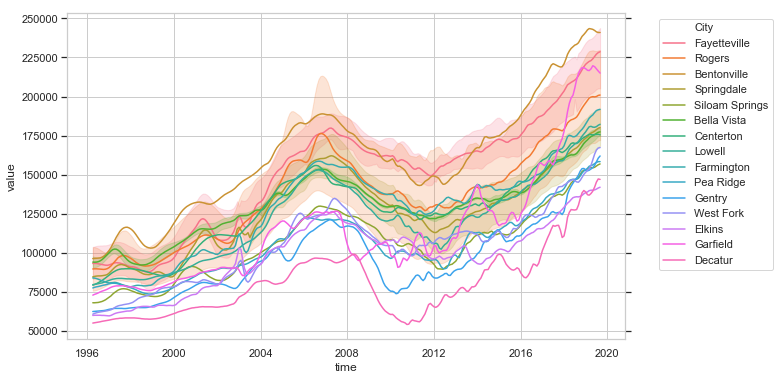

In [53]:
#Plot all the zipcodes from Washington & Benton county
plt.figure(figsize=(10, 6))
ax = sns.lineplot(x="time", y="value", hue="City",
                   data=dfARCountyMelted)
ax.yaxis.set_ticks_position('both')

plt.legend(ncol=1, bbox_to_anchor=(1.05, 1));

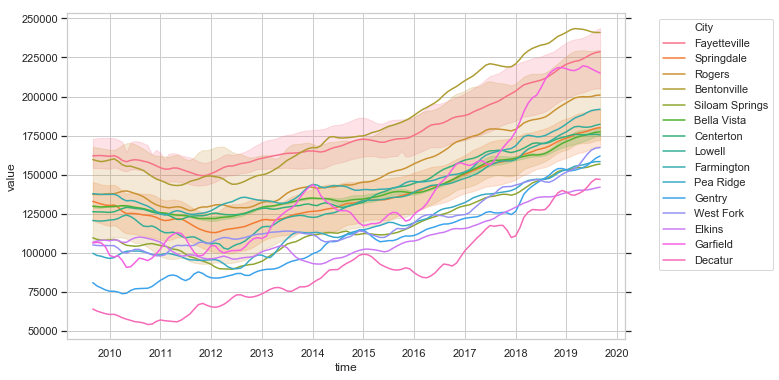

In [54]:
#Plot all the zipcodes with data after 2009
plt.figure(figsize=(10, 6))
ax = sns.lineplot(x="time", y="value", hue="City",
                   data=dfARCountyMelted2009)
ax.yaxis.set_ticks_position('both')

plt.legend(ncol=1, bbox_to_anchor=(1.05, 1));

In [55]:
#Sort dataframe be increase in value and plot
sortedvals = dfARCountyMelted2009.sort_values(by=['Increase'], ascending=False)

In [56]:
increase12 = sortedvals.loc[sortedvals['Increase'] > 12]

In [57]:
groupedvals = increase12.groupby(['RegionName'])

Plot the Cities with increase over 12%. These are the cities we will analyze in the study since they present the biggest ROI.

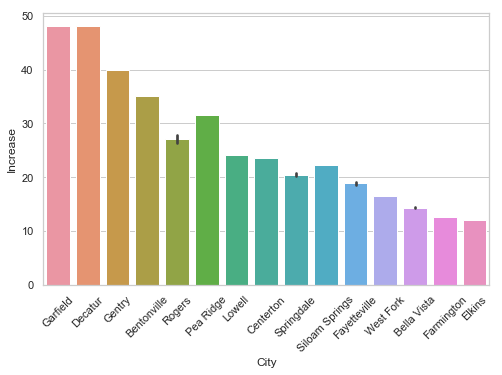

In [58]:
plt.figure(figsize=(8, 5))
sns.set(style="whitegrid")
plt.xticks(rotation=45)
ax = sns.barplot(x="City", y="Increase", data=increase12)

In [59]:
#Create dataset by county
WashingtonCounty = dfARCountyMelted2009.loc[dfARCountyMelted2009['CountyName'] == 'Washington County']
BentonCounty = dfARCountyMelted2009.loc[dfARCountyMelted2009['CountyName'] == 'Benton County']

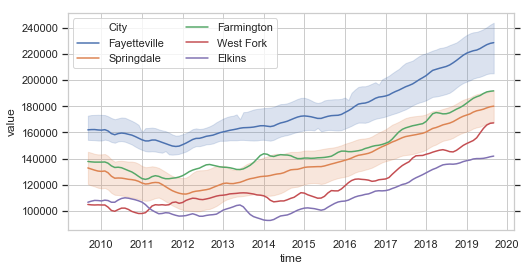

In [60]:
#Washington county plot
plt.figure(figsize=(8, 4))
ax = sns.lineplot(x="time", y="value", hue="City",
                   data=WashingtonCounty)
ax.yaxis.set_ticks_position('both')
plt.legend(loc='upper left', ncol=2);

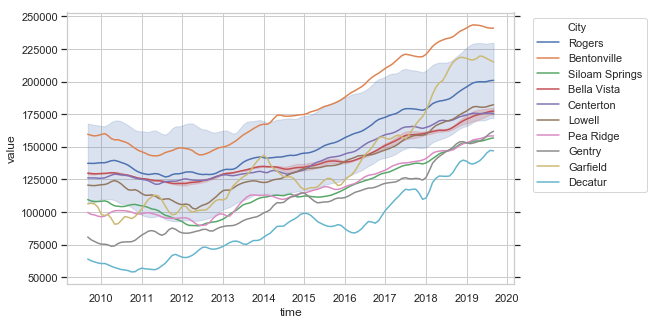

In [61]:
#Benton county plot
plt.figure(figsize=(8, 5))
ax = sns.lineplot(x="time", y="value", hue="City",
                   data=BentonCounty)
ax.yaxis.set_ticks_position('both')
plt.legend(loc='upper left', ncol=1, bbox_to_anchor=(1.03, 1));

# Zip Codes Time Series

>- Data goes from 2009-09-01 to 2019-09-01
- Cities with an overall increase of 12% were selected

In [62]:
CityList = ['Decatur', 'Gentry', 'Garfield', 'Bentonville', 'Rogers', 'Pea Ridge', 'Lowell', 'Centerton']

In [63]:
dfARStudy = dfARCountyMelted2009.loc[dfARCountyMelted2009['City'].isin(CityList)] 

In [64]:
#Size rank is to compare how big of a city is (urbanization level)
#Size rank #1 is the biggest city, therefore, the higher the number, the less urbanized the zipcode is
sizerankgrouped = dfARStudy.groupby(['SizeRank']).mean()
sizerankgrouped.head(10)

,RegionID,RegionName,AvgPrice_2013,AvgPrice_2018,Increase,value
SizeRank,,,,,,
1483,89745,72758,166100.0,200950.0,20.981337,183846.280992
1542,89743,72756,104500.0,139200.0,33.205742,122957.024793
1844,89712,72712,152100.0,205650.0,35.207101,182296.694215
7525,89718,72719,126450.0,156200.0,23.527086,142008.264463
7806,89737,72745,117050.0,145200.0,24.049551,134971.074380
9606,89740,72751,98550.0,129600.0,31.506849,117451.239669
9632,89727,72734,85350.0,119500.0,40.011716,107500.826446
11080,89725,72732,104300.0,154550.0,48.178332,137316.528926
13257,89720,72722,66500.0,98500.0,48.120301,89305.785124


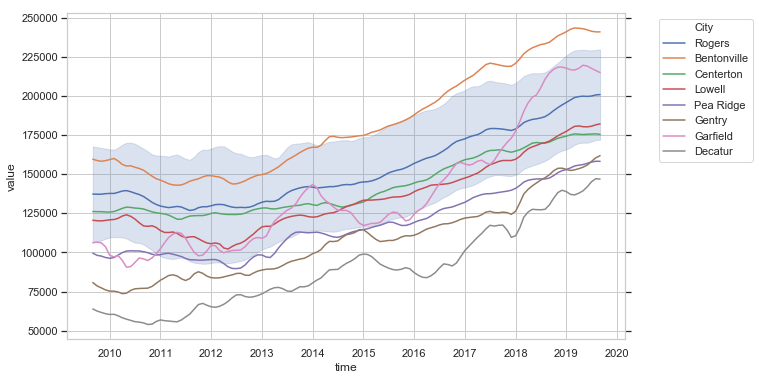

In [65]:
#Plot all the zipcodes under study to visually see their trend
plt.figure(figsize=(10, 6))
ax = sns.lineplot(x="time", y="value", hue="City",
                   data=dfARStudy)
ax.yaxis.set_ticks_position('both')

plt.legend(ncol=1, bbox_to_anchor=(1.05, 1));

##### DF per city

In [117]:
#Create a dataframe per city
Decatur = dfARStudy.loc[dfARStudy['City'] == 'Decatur'] 
Gentry = dfARStudy.loc[dfARStudy['City'] == 'Gentry']
Garfield = dfARStudy.loc[dfARStudy['City'] == 'Garfield'] 
Bentonville = dfARStudy.loc[dfARStudy['City'] == 'Bentonville'] 
Rogers = dfARStudy.loc[dfARStudy['City'] == 'Rogers']
PeaRidge = dfARStudy.loc[dfARStudy['City'] == 'Pea Ridge'] 
Lowell = dfARStudy.loc[dfARStudy['City'] == 'Lowell'] 
Centerton = dfARStudy.loc[dfARStudy['City'] == 'Centerton'] 

#Rogers has 2 zipcodes and we need a single value per time period
Rogers = Rogers.groupby(['time','City', 'State', 'Metro', 'CountyName']).mean().reset_index()

In [118]:
#list of df
Cityts = [Decatur, Gentry, Garfield, Bentonville, Rogers, PeaRidge, Lowell, Centerton]

Prepare ts for modeling

In [119]:
#Drop unnecessary columns in preparation for time series
for i, df in enumerate(Cityts):
    df.drop(columns=['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank', 'AvgPrice_2013', 'AvgPrice_2018', 'Increase'], inplace=True)
    df.set_index('time', inplace=True)

# Stationarity Test

> Check the Stationarity using Dickie Fuller test. This will let us see what data transformations are necessary in order to meet the stationarity assumption for ARIMA. Note that in case the only transformation needed is differencing, ARIMA will take care of it.

> In Dickie Fuller test **H0** = series is not stationary

In [141]:
#list of ts
Cityts = [Decatur, Gentry, Garfield, Bentonville, Rogers, PeaRidge, Lowell, Centerton]

**Original Series**

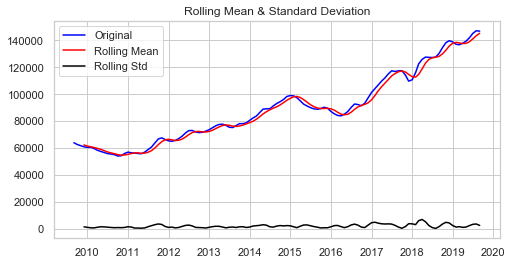

Test Statistic             0.425110
p-value                    0.982410
#Lags Used                 9.000000
Number of observation    111.000000
Critical Value(1%)        -3.490683
Critical Value(5%)        -2.887952
Critical Value(10%)       -2.580857
dtype: float64
/n


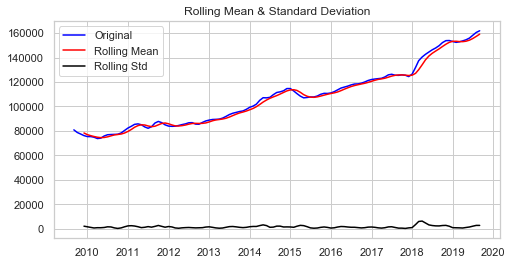

Test Statistic             2.506814
p-value                    0.999052
#Lags Used                11.000000
Number of observation    109.000000
Critical Value(1%)        -3.491818
Critical Value(5%)        -2.888444
Critical Value(10%)       -2.581120
dtype: float64
/n


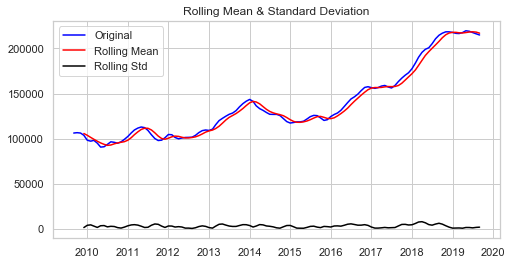

Test Statistic             0.987308
p-value                    0.994130
#Lags Used                11.000000
Number of observation    109.000000
Critical Value(1%)        -3.491818
Critical Value(5%)        -2.888444
Critical Value(10%)       -2.581120
dtype: float64
/n


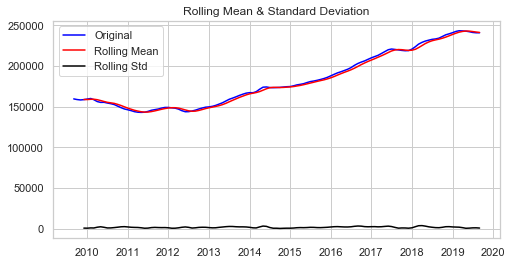

Test Statistic             0.568347
p-value                    0.986809
#Lags Used                 4.000000
Number of observation    116.000000
Critical Value(1%)        -3.488022
Critical Value(5%)        -2.886797
Critical Value(10%)       -2.580241
dtype: float64
/n


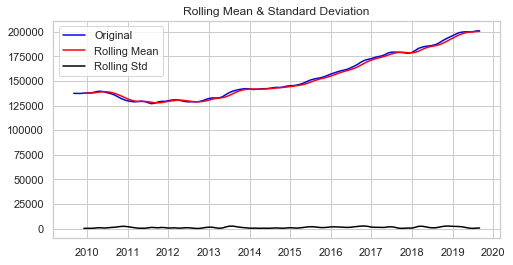

Test Statistic             0.448740
p-value                    0.983229
#Lags Used                 6.000000
Number of observation    114.000000
Critical Value(1%)        -3.489058
Critical Value(5%)        -2.887246
Critical Value(10%)       -2.580481
dtype: float64
/n


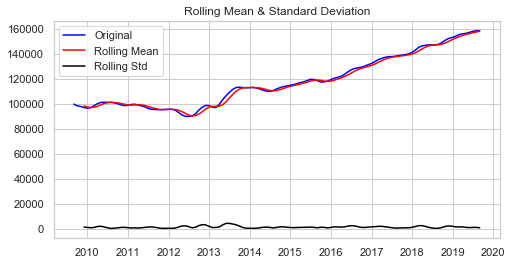

Test Statistic             0.811723
p-value                    0.991823
#Lags Used                 5.000000
Number of observation    115.000000
Critical Value(1%)        -3.488535
Critical Value(5%)        -2.887020
Critical Value(10%)       -2.580360
dtype: float64
/n


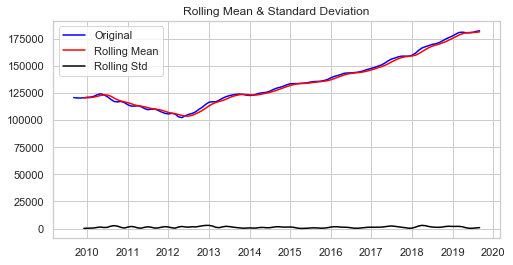

Test Statistic             0.191013
p-value                    0.971753
#Lags Used                 8.000000
Number of observation    112.000000
Critical Value(1%)        -3.490131
Critical Value(5%)        -2.887712
Critical Value(10%)       -2.580730
dtype: float64
/n


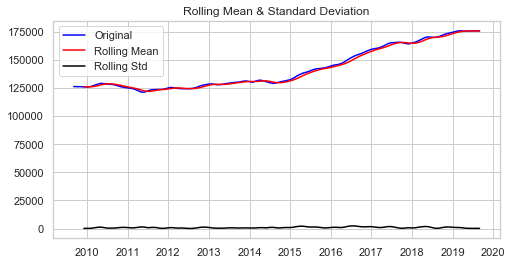

Test Statistic             0.214430
p-value                    0.973059
#Lags Used                 3.000000
Number of observation    117.000000
Critical Value(1%)        -3.487517
Critical Value(5%)        -2.886578
Critical Value(10%)       -2.580124
dtype: float64
/n


In [69]:
#Run the Dikie Fuller test for each city under study to assess stationarity
for i, df in enumerate(Cityts):
    output = stationarityTest(df, 4)
    
    print(output)
    print('/n')

**Log Transformed**

In [70]:
#Log Transform data
#Run the Dikie Fuller test for each city under study to assess stationarity
for i, df in enumerate(Cityts):
    tslog = np.log(df)
    dftest = adfuller(tslog['value'])
    dfoutput = pd.Series(dftest[1], index =['p-value'])
    print('--City{}: {} '.format(i,dfoutput))

--City0: p-value    0.880897
dtype: float64 
--City1: p-value    0.996841
dtype: float64 
--City2: p-value    0.986154
dtype: float64 
--City3: p-value    0.976559
dtype: float64 
--City4: p-value    0.980378
dtype: float64 
--City5: p-value    0.979734
dtype: float64 
--City6: p-value    0.962181
dtype: float64 
--City7: p-value    0.968364
dtype: float64 


**Differenced**

In [71]:
#Differentiate every city up to 3 times
for i, df in enumerate(Cityts):
    print('////////City {}////////'.format(i))
    for j in [1,2,3]:
        data_diff = df.diff(periods=j)
        data_diff.dropna(inplace=True)
        dftest = adfuller(data_diff['value'])
        dfoutput = pd.Series(dftest[1], index =['p-value'])
        print('Diff {}: {}'.format(j,dfoutput))

////////City 0////////
Diff 1: p-value    0.022104
dtype: float64
Diff 2: p-value    0.027764
dtype: float64
Diff 3: p-value    0.027517
dtype: float64
////////City 1////////
Diff 1: p-value    0.048793
dtype: float64
Diff 2: p-value    0.013873
dtype: float64
Diff 3: p-value    0.053915
dtype: float64
////////City 2////////
Diff 1: p-value    0.005592
dtype: float64
Diff 2: p-value    0.004179
dtype: float64
Diff 3: p-value    0.008602
dtype: float64
////////City 3////////
Diff 1: p-value    0.081631
dtype: float64
Diff 2: p-value    0.276397
dtype: float64
Diff 3: p-value    0.100784
dtype: float64
////////City 4////////
Diff 1: p-value    0.192325
dtype: float64
Diff 2: p-value    0.307488
dtype: float64
Diff 3: p-value    0.034017
dtype: float64
////////City 5////////
Diff 1: p-value    0.004463
dtype: float64
Diff 2: p-value    0.082403
dtype: float64
Diff 3: p-value    0.0555
dtype: float64
////////City 6////////
Diff 1: p-value    0.299292
dtype: float64
Diff 2: p-value    0.052

**Log Transformed & Differenced**

In [72]:
#Differentiate every city up to 3 times
#Log transformed

for i, df in enumerate(Cityts):
    print('////////City {}////////'.format(i))
    for j in [1,2,3]:
        tslog = np.log(df)
        data_diff = tslog.diff(periods=j)
        data_diff.dropna(inplace=True)
        dftest = adfuller(data_diff['value'])
        dfoutput = pd.Series(dftest[1], index =['p-value'])
        print('Diff {}: {}'.format(j,dfoutput))

////////City 0////////
Diff 1: p-value    0.004834
dtype: float64
Diff 2: p-value    0.006341
dtype: float64
Diff 3: p-value    0.005516
dtype: float64
////////City 1////////
Diff 1: p-value    0.018505
dtype: float64
Diff 2: p-value    0.000197
dtype: float64
Diff 3: p-value    0.005801
dtype: float64
////////City 2////////
Diff 1: p-value    0.001935
dtype: float64
Diff 2: p-value    0.001323
dtype: float64
Diff 3: p-value    0.000182
dtype: float64
////////City 3////////
Diff 1: p-value    0.02404
dtype: float64
Diff 2: p-value    0.203796
dtype: float64
Diff 3: p-value    0.093758
dtype: float64
////////City 4////////
Diff 1: p-value    0.139972
dtype: float64
Diff 2: p-value    0.279632
dtype: float64
Diff 3: p-value    0.027691
dtype: float64
////////City 5////////
Diff 1: p-value    0.003136
dtype: float64
Diff 2: p-value    0.064365
dtype: float64
Diff 3: p-value    0.054384
dtype: float64
////////City 6////////
Diff 1: p-value    0.204545
dtype: float64
Diff 2: p-value    0.03

**Rolling Mean Substraction**

In [73]:
for i, ts in enumerate(Cityts):
    rolmean = ts.rolling(window = 2).mean()
    data_minus_rolmean = ts - rolmean
    data_minus_rolmean.dropna(inplace=True)
    
    dftest = adfuller(data_minus_rolmean['value'])
    dfoutput = pd.Series(dftest[1], index =['p-value'])
    print('--City{}: {} '.format(i,dfoutput))

--City0: p-value    0.022104
dtype: float64 
--City1: p-value    0.048793
dtype: float64 
--City2: p-value    0.005592
dtype: float64 
--City3: p-value    0.081631
dtype: float64 
--City4: p-value    0.192325
dtype: float64 
--City5: p-value    0.004463
dtype: float64 
--City6: p-value    0.299292
dtype: float64 
--City7: p-value    0.013647
dtype: float64 


**Diff & Rolling Mean**

In [74]:
#Data Diff & Rolling Mean
for i, ts in enumerate(Cityts):
    print('////////City {}////////'.format(i))
    for j in [1,2,3]:
        
        rolmean = ts.rolling(window = 2).mean()
        data_minus_rolmean = ts - rolmean
        data_minus_rolmean.dropna(inplace=True)
        
        data_diff = data_minus_rolmean.diff(periods=j)
        data_diff.dropna(inplace=True)
        dftest = adfuller(data_diff['value'])
        dfoutput = pd.Series(dftest[1], index =['p-value'])
        print('Diff {}: {}'.format(j,dfoutput))

////////City 0////////
Diff 1: p-value    0.012777
dtype: float64
Diff 2: p-value    0.008132
dtype: float64
Diff 3: p-value    0.002008
dtype: float64
////////City 1////////
Diff 1: p-value    0.000025
dtype: float64
Diff 2: p-value    0.00008
dtype: float64
Diff 3: p-value    0.000012
dtype: float64
////////City 2////////
Diff 1: p-value    0.000371
dtype: float64
Diff 2: p-value    0.00055
dtype: float64
Diff 3: p-value    0.001099
dtype: float64
////////City 3////////
Diff 1: p-value    7.421523e-11
dtype: float64
Diff 2: p-value    5.019375e-08
dtype: float64
Diff 3: p-value    0.000156
dtype: float64
////////City 4////////
Diff 1: p-value    7.099434e-11
dtype: float64
Diff 2: p-value    8.629395e-08
dtype: float64
Diff 3: p-value    0.000347
dtype: float64
////////City 5////////
Diff 1: p-value    2.025235e-12
dtype: float64
Diff 2: p-value    0.000011
dtype: float64
Diff 3: p-value    0.000037
dtype: float64
////////City 6////////
Diff 1: p-value    0.000077
dtype: float64
Diff

> After transforming the data I was able to see that most of my zipcodes require differencing to meet stationarity requirement. A couple of zipcodes will be log transformed in addition to differencing in order to meet stationarity assumption. 

- Difference: Decatur, Gentry, Garfield, PeaRidge, Centerton
- Difference & Log Transformed: Rogers, Bentonville, Lowell 

*Eventhough Rogers, Bentonville and Lowell could have also used rolling mean subtraction, I will use log transform since forecasted results are easier to bring back to original units than with rolling mean (in my opinion)* 

# Seasonality Check

In [75]:
# Assess seasonality of data 
def check_seasonality(df, col):
    # Use Statsmodels seasonal_decompose function to split time series variation into trend, seasonal variation and white noise
    result = seasonal_decompose(df)
    # Plot Trend, Seasonal and Residual on 3 consecutive axes
    result.trend.plot(ax=axes[0][col])
    axes[0][col].set_ylabel('Trend')
    result.seasonal.plot(ax=axes[1][col])
    axes[1][col].set_ylabel('Seasonal')
    result.resid.plot(ax=axes[2][col])
    axes[2][col].set_ylabel('Residual')

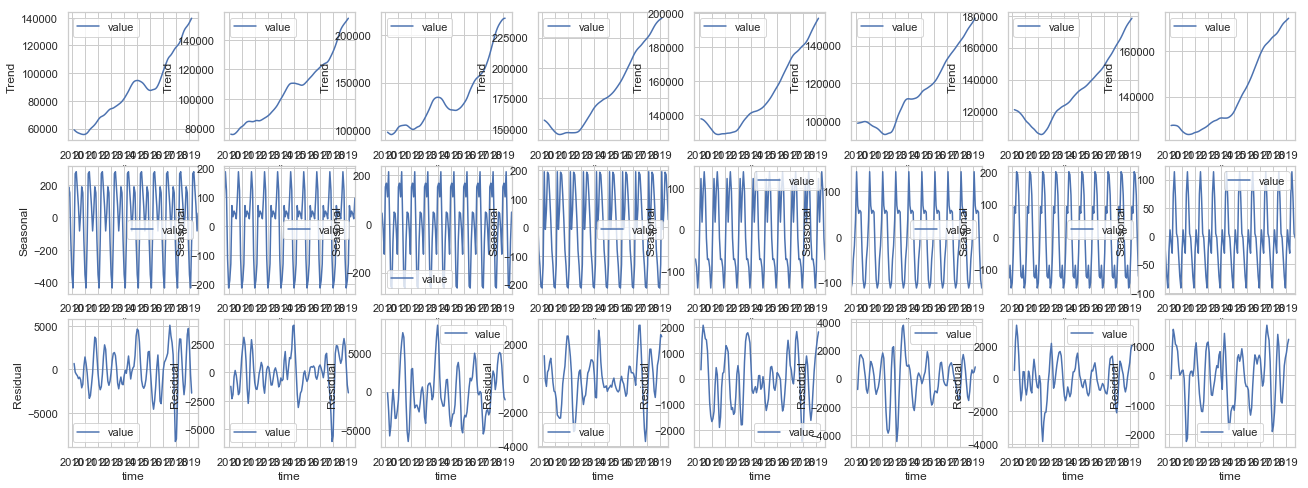

In [77]:
# Create 8X3 grid of plots, each column contains one city, each row contains a trend, seasonal or white noise component
fig, axes = plt.subplots(3,8, figsize=(22,8))
for i, ts in enumerate(Cityts):
    check_seasonality(ts,i)

> Looks like every city time series has seasonality, therefore, we will have to take care of seasonality when creating our model.

# Data Transformation

The approproate data transformation will be applied to the ts based on the Stationarity check done in previous sections.

**Difference**

In [125]:
Diff_Decatur = Decatur.copy()
Diff_Gentry = Gentry.copy()
Diff_Garfield = Garfield.copy()
Diff_PeaRidge = PeaRidge.copy()
Diff_Centerton = Centerton.copy()

Diff_Decatur = Diff_Decatur.diff(periods=1)
Diff_Gentry = Diff_Gentry.diff(periods=1)
Diff_Garfield = Diff_Garfield.diff(periods=1)
Diff_PeaRidge = Diff_PeaRidge.diff(periods=1)
Diff_Centerton = Diff_Centerton.diff(periods=1)

#This list will be used for ACF and PACF. For the actual modeling we will use the original ts and let ARIMA take care of differencing.
PreDiff_cities = [Diff_Decatur, Diff_Gentry, Diff_Garfield, Diff_PeaRidge, Diff_Centerton]

#drop NaNs from differenced ts
for i, ts in enumerate(PreDiff_cities):
    ts.dropna(inplace=True)

**Log & Diff**

In [80]:
#calculate rolling mean using user defined function
# rolmean_Bentonville = tsrollingmean(Bentonville)
# rolmean_Rogers = tsrollingmean(Rogers)
# rolmean_Lowell = tsrollingmean(Lowell)

In [83]:
#This list will be used for modeling
# Rolmean_cities = [rolmean_Bentonville, rolmean_Rogers, rolmean_Lowell]

In [85]:
#manually differenciate rolling mean transformed ts
# diffrollmean_Bentonville = rolmean_Bentonville.diff(periods=1)
# diffrollmean_Bentonville.dropna(inplace=True)
# diffrollmean_Rogers = rolmean_Rogers.diff(periods=1)
# diffrollmean_Rogers.dropna(inplace=True)
# diffrollmean_Lowell = rolmean_Lowell.diff(periods=1)
# diffrollmean_Lowell.dropna(inplace=True)

In [87]:
# diffrolmean_cities = [diffrollmean_Bentonville, diffrollmean_Rogers, diffrollmean_Lowell]

In [135]:
log_Bentonville = np.log(Bentonville)
log_Rogers = np.log(Rogers)
log_Lowell = np.log(Lowell)

difflog_Bentonville = log_Bentonville.diff(periods=1)
difflog_Bentonville.dropna(inplace=True)
difflog_Rogers = log_Rogers.diff(periods=1)
difflog_Rogers.dropna(inplace=True)
difflog_Lowell = log_Lowell.diff(periods=1)
difflog_Lowell.dropna(inplace=True)

In [138]:
log_cities = [log_Bentonville, log_Rogers, log_Lowell]
difflog_cities = [difflog_Bentonville, difflog_Rogers, difflog_Lowell]

# ACF PACF

Before plotting ACF and PACF we need to make sure the time series is stationary. This is the reason why we transformed before plotting.

In [130]:
def check_autocorrelation(df, lags, col):
    plot_acf(df, lags=lags, ax=ax[0][col])
    plot_pacf(df, lags=lags, ax=ax[1][col])

**Diff_cities**

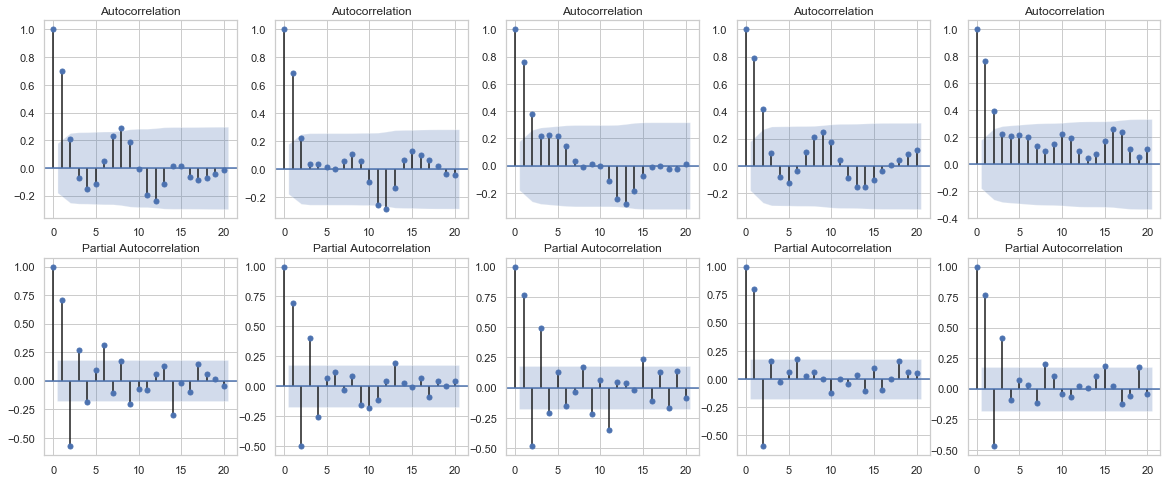

In [131]:
# ACF and PACF of Diff_cities
fig,ax = plt.subplots(2,5,figsize=(20,8))

for i, ts in enumerate(PreDiff_cities):
    check_autocorrelation(ts, 20, i)

**Log & Diff cities**

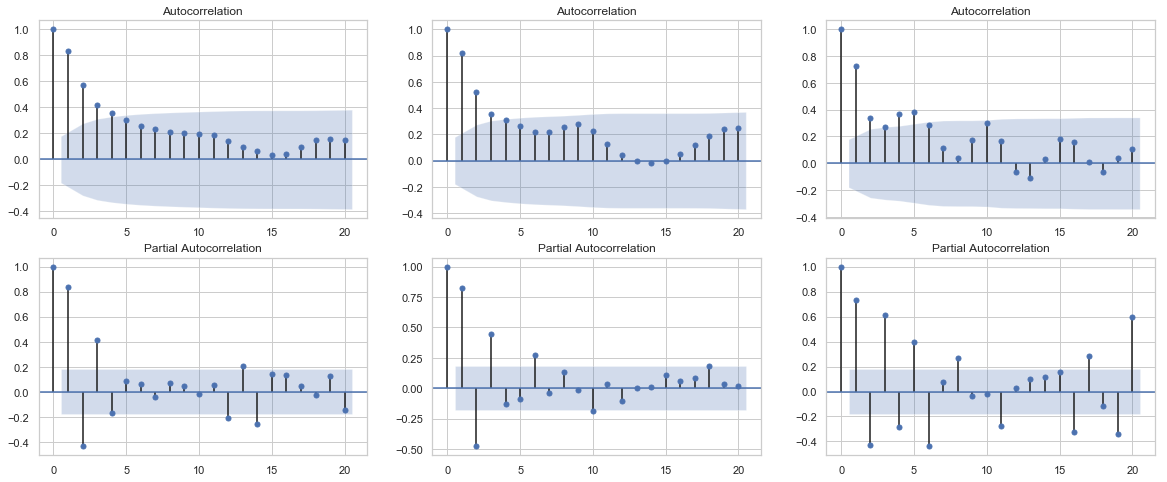

In [137]:
#ACF and PACF of rolling mean & diff cities
fig,ax = plt.subplots(2,3,figsize=(20,8))

for i, ts in enumerate(difflog_cities):
    check_autocorrelation(ts, 20, i)

# ARIMA Modeling

**pm.auto_arima:** Automatically discover the optimal order for an ARIMA model

auto_arima works by conducting different tests (i.e., Kwiatkowski–Phillips–Schmidt–Shin, Augmented Dickey-Fuller 
or Phillips–Perron) to determine the order of differencing d and the fitting models within ranges of defined startp, maxp, startq, maxq. If the seasonal optional is enabled, auto-ARIMA also seeks to identify the optimal P and Q hyper- parameters after conducting the Canova-Hansen to determine the optimal order of seasonal differencing, D.

https://www.alkaline-ml.com/pmdarima/modules/classes.html

In [263]:
#This lists will be used for modeling
Diff_cities = [Decatur, Gentry, Garfield, PeaRidge, Centerton]
log_cities = [log_Bentonville, log_Rogers, log_Lowell]

In [106]:
#Check the number of values to include on my test data
#121 is the total number of observations in my dataset
121 - (121 * 0.8)

24.19999999999999

City:  0
ADF Statistic Residual: -4.758691
p-value: 0.000065


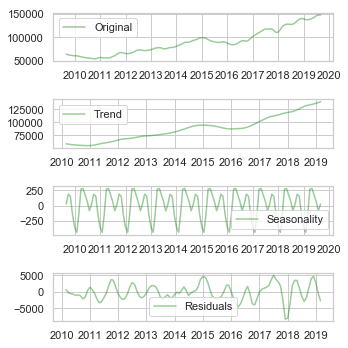

Fit ARIMA: order=(1, 2, 1); AIC=1566.402, BIC=1576.617, Fit time=0.094 seconds
Fit ARIMA: order=(0, 2, 0); AIC=1595.513, BIC=1600.620, Fit time=0.002 seconds
Fit ARIMA: order=(1, 2, 0); AIC=1590.624, BIC=1598.285, Fit time=0.037 seconds
Fit ARIMA: order=(0, 2, 1); AIC=1565.047, BIC=1572.709, Fit time=0.059 seconds
Fit ARIMA: order=(0, 2, 2); AIC=1563.559, BIC=1573.774, Fit time=0.038 seconds
Fit ARIMA: order=(1, 2, 3); AIC=1533.024, BIC=1548.347, Fit time=0.201 seconds
Fit ARIMA: order=(0, 2, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 2, 3); AIC=1535.024, BIC=1552.901, Fit time=0.327 seconds
Fit ARIMA: order=(1, 2, 2); AIC=1548.138, BIC=1560.907, Fit time=0.077 seconds
Fit ARIMA: order=(1, 2, 4); AIC=1534.079, BIC=1551.956, Fit time=0.284 seconds
Fit ARIMA: order=(2, 2, 4); AIC=1535.689, BIC=1556.120, Fit time=0.359 seconds
Total fit time: 1.487 seconds
                             ARIMA Model Results                              
Dep. Variable:                   D

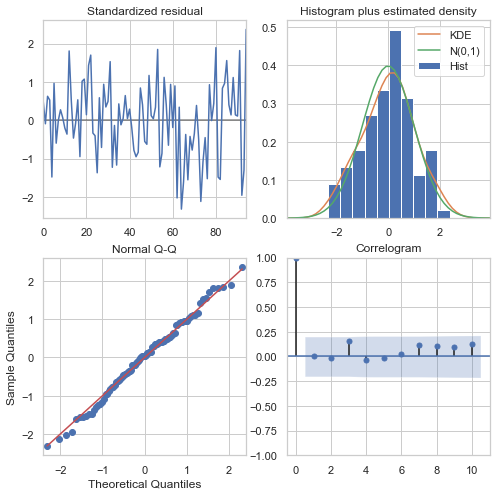

The Root Mean Squared Error of our forcast is 10587.87
The root mean squared error of City: 0 of our forcast isvalue    11.856
dtype: float64% of mean housing price from 2019.


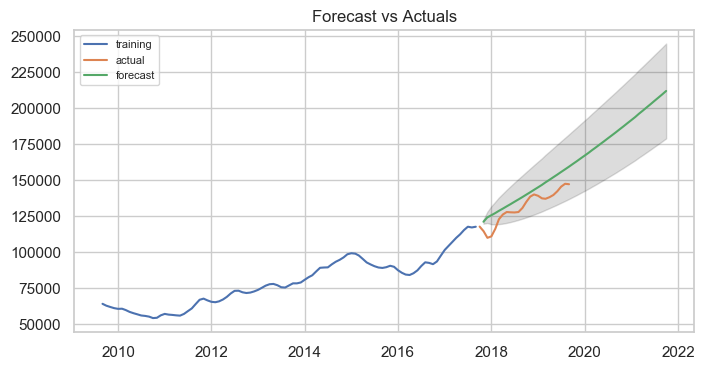

City:  1
ADF Statistic Residual: -3.730562
p-value: 0.003703


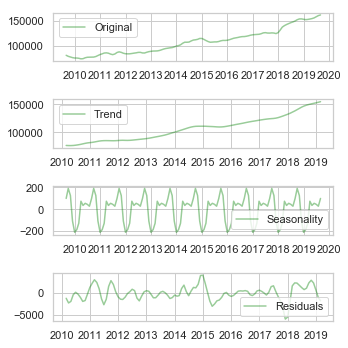

Fit ARIMA: order=(1, 2, 1); AIC=1532.048, BIC=1542.263, Fit time=0.070 seconds
Fit ARIMA: order=(0, 2, 0); AIC=1566.972, BIC=1572.080, Fit time=0.002 seconds
Fit ARIMA: order=(1, 2, 0); AIC=1563.034, BIC=1570.696, Fit time=0.036 seconds
Fit ARIMA: order=(0, 2, 1); AIC=1530.234, BIC=1537.896, Fit time=0.049 seconds
Fit ARIMA: order=(0, 2, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 2, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 0.179 seconds
                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                   95
Model:                 ARIMA(0, 2, 1)   Log Likelihood                -762.117
Method:                       css-mle   S.D. of innovations            734.198
Date:                Mon, 02 Dec 2019   AIC                           1530.234
Time:                        00:25:16   BIC                           1537.896
Sample:                             2   HQIC  

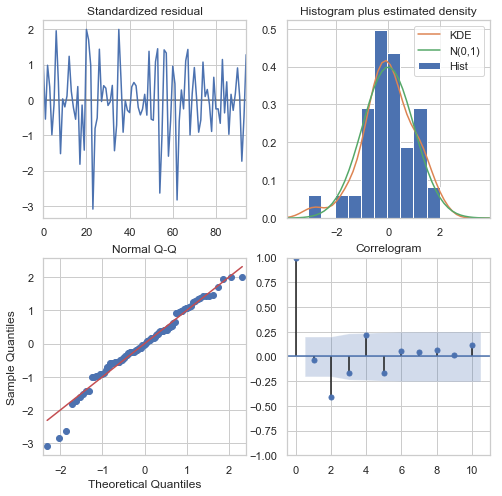

The Root Mean Squared Error of our forcast is 10759.84
The root mean squared error of City: 1 of our forcast isvalue    10.009
dtype: float64% of mean housing price from 2019.


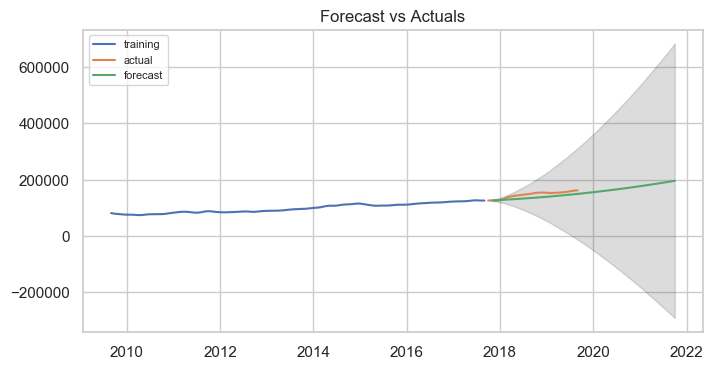

City:  2
ADF Statistic Residual: -4.705077
p-value: 0.000082


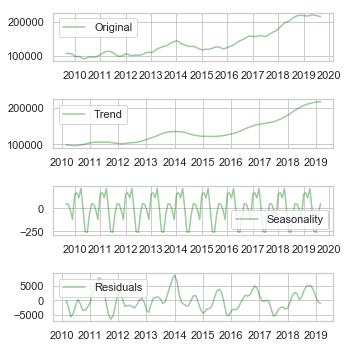

Fit ARIMA: order=(1, 2, 1); AIC=1675.869, BIC=1686.085, Fit time=0.082 seconds
Fit ARIMA: order=(0, 2, 0); AIC=1704.956, BIC=1710.064, Fit time=0.002 seconds
Fit ARIMA: order=(1, 2, 0); AIC=1698.338, BIC=1706.000, Fit time=0.048 seconds
Fit ARIMA: order=(0, 2, 1); AIC=1673.965, BIC=1681.627, Fit time=0.038 seconds
Fit ARIMA: order=(0, 2, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 2, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 0.205 seconds
                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                   95
Model:                 ARIMA(0, 2, 1)   Log Likelihood                -833.983
Method:                       css-mle   S.D. of innovations           1566.559
Date:                Mon, 02 Dec 2019   AIC                           1673.965
Time:                        00:25:17   BIC                           1681.627
Sample:                             2   HQIC  

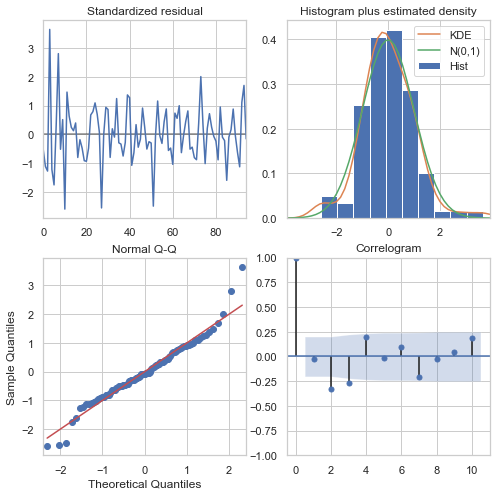

The Root Mean Squared Error of our forcast is 24202.1
The root mean squared error of City: 2 of our forcast isvalue    17.625
dtype: float64% of mean housing price from 2019.


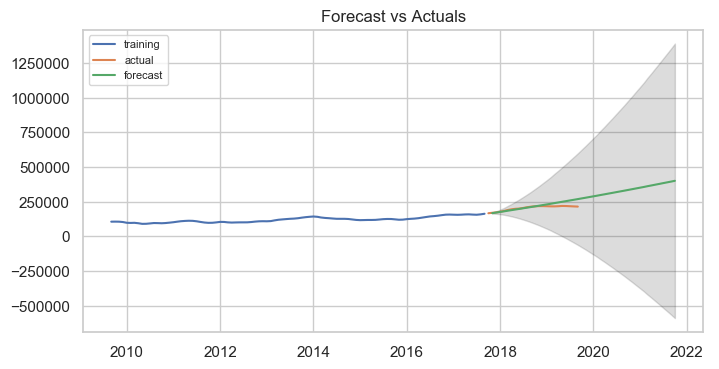

City:  3
ADF Statistic Residual: -4.047229
p-value: 0.001182


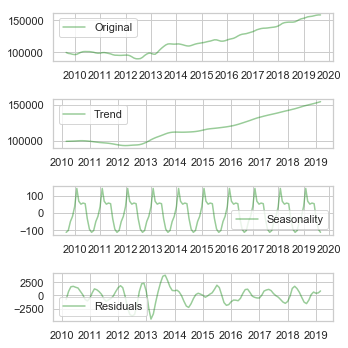

Fit ARIMA: order=(1, 1, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0); AIC=1619.154, BIC=1624.283, Fit time=0.003 seconds
Fit ARIMA: order=(1, 1, 0); AIC=1519.465, BIC=1527.159, Fit time=0.036 seconds
Fit ARIMA: order=(0, 1, 1); AIC=1518.605, BIC=1526.298, Fit time=0.060 seconds
Fit ARIMA: order=(0, 1, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 2); AIC=1457.627, BIC=1470.448, Fit time=0.153 seconds
Fit ARIMA: order=(2, 1, 2); AIC=1459.363, BIC=1474.749, Fit time=0.206 seconds
Fit ARIMA: order=(1, 1, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 0.622 seconds
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   96
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -723.813
Method:                       css-mle   S.D. of innovations           

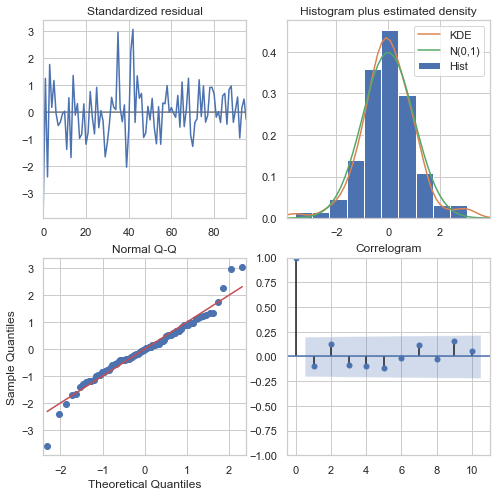

The Root Mean Squared Error of our forcast is 7897.82
The root mean squared error of City: 3 of our forcast isvalue    6.724
dtype: float64% of mean housing price from 2019.


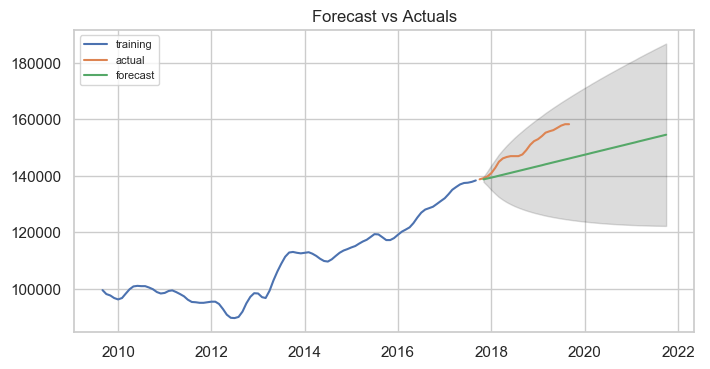

City:  4
ADF Statistic Residual: -4.594046
p-value: 0.000132


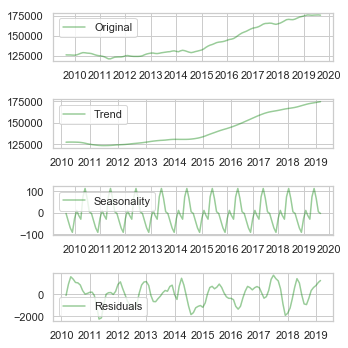

Fit ARIMA: order=(1, 2, 1); AIC=1418.049, BIC=1428.265, Fit time=0.072 seconds
Fit ARIMA: order=(0, 2, 0); AIC=1446.228, BIC=1451.335, Fit time=0.002 seconds
Fit ARIMA: order=(1, 2, 0); AIC=1439.707, BIC=1447.369, Fit time=0.044 seconds
Fit ARIMA: order=(0, 2, 1); AIC=1416.292, BIC=1423.954, Fit time=0.033 seconds
Fit ARIMA: order=(0, 2, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 2, 2); AIC=1397.384, BIC=1410.153, Fit time=0.088 seconds
Fit ARIMA: order=(2, 2, 2); AIC=1392.806, BIC=1408.129, Fit time=0.135 seconds
Fit ARIMA: order=(2, 2, 1); AIC=1400.852, BIC=1413.621, Fit time=0.089 seconds
Fit ARIMA: order=(2, 2, 3); AIC=1391.359, BIC=1409.236, Fit time=0.187 seconds
Fit ARIMA: order=(3, 2, 4); AIC=1395.278, BIC=1418.262, Fit time=0.492 seconds
Fit ARIMA: order=(1, 2, 3); AIC=1389.373, BIC=1404.696, Fit time=0.174 seconds
Fit ARIMA: order=(1, 2, 4); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 2, 4); AIC=1393.353, BIC=1413.784, Fit time=0.318 secon

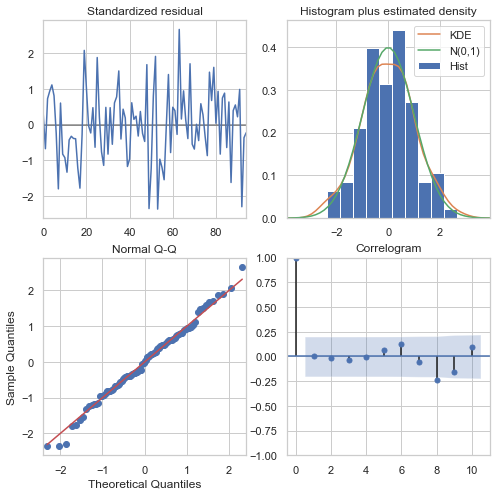

The Root Mean Squared Error of our forcast is 10711.24
The root mean squared error of City: 4 of our forcast isvalue    7.543
dtype: float64% of mean housing price from 2019.


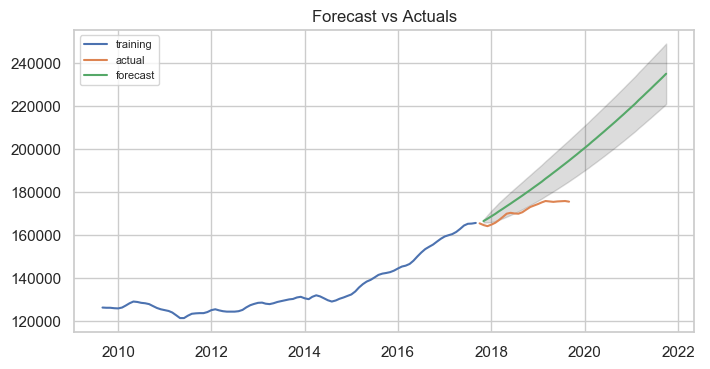

AIC list: [1533.0239787160647, 1530.2341365915913, 1673.965143932469, 1457.6267221909934, 1389.3731841157419]
RMSE list: [value    11.855749
dtype: float64, value    10.009074
dtype: float64, value    17.625043
dtype: float64, value    6.724342
dtype: float64, value    7.542685
dtype: float64]


(None, None)

In [376]:
ARIMA_modeling(Diff_cities)

City:  0
ADF Statistic Residual: -5.734593
p-value: 0.000001


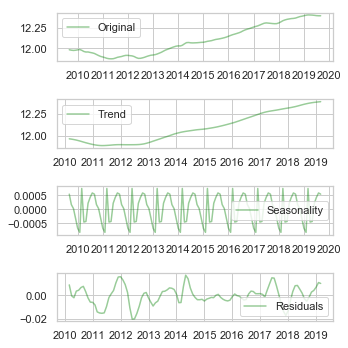

Fit ARIMA: order=(1, 2, 1); AIC=-794.933, BIC=-784.718, Fit time=0.126 seconds
Fit ARIMA: order=(0, 2, 0); AIC=-776.048, BIC=-770.940, Fit time=0.011 seconds
Fit ARIMA: order=(1, 2, 0); AIC=-782.351, BIC=-774.689, Fit time=0.040 seconds
Fit ARIMA: order=(0, 2, 1); AIC=-796.590, BIC=-788.928, Fit time=0.041 seconds
Fit ARIMA: order=(0, 2, 2); AIC=-796.600, BIC=-786.384, Fit time=0.079 seconds
Fit ARIMA: order=(1, 2, 3); AIC=-818.309, BIC=-802.986, Fit time=0.192 seconds
Fit ARIMA: order=(0, 2, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 2, 3); AIC=-818.555, BIC=-800.678, Fit time=0.937 seconds
Fit ARIMA: order=(2, 2, 2); AIC=-808.504, BIC=-793.180, Fit time=0.502 seconds
Fit ARIMA: order=(2, 2, 4); AIC=-817.293, BIC=-796.862, Fit time=1.924 seconds
Fit ARIMA: order=(1, 2, 2); AIC=-808.094, BIC=-795.324, Fit time=0.160 seconds
Fit ARIMA: order=(3, 2, 4); AIC=-815.812, BIC=-792.827, Fit time=1.247 seconds
Fit ARIMA: order=(3, 2, 3); AIC=-816.745, BIC=-796.314, Fit time

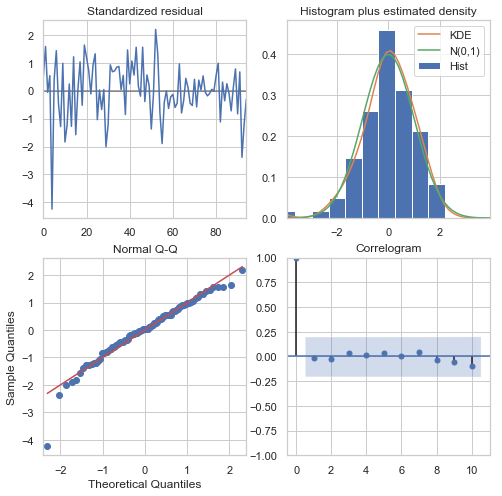

The Root Mean Squared Error of our forcast is 0.08
The root mean squared error of City: 0 of our forcast isvalue    0.682
dtype: float64% of mean housing price from 2019.


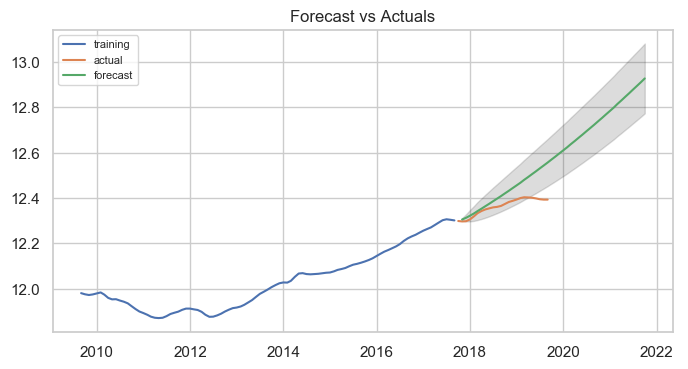

City:  1
ADF Statistic Residual: -4.246953
p-value: 0.000548


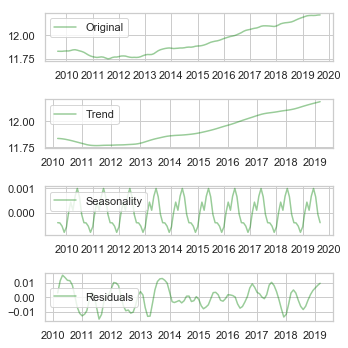

Fit ARIMA: order=(1, 1, 1); AIC=-840.703, BIC=-830.446, Fit time=0.075 seconds
Fit ARIMA: order=(0, 1, 0); AIC=-707.051, BIC=-701.923, Fit time=0.006 seconds
Fit ARIMA: order=(1, 1, 0); AIC=-812.368, BIC=-804.675, Fit time=0.034 seconds
Fit ARIMA: order=(0, 1, 1); AIC=-793.339, BIC=-785.646, Fit time=0.033 seconds
Fit ARIMA: order=(2, 1, 1); AIC=-841.151, BIC=-828.330, Fit time=0.117 seconds
Fit ARIMA: order=(2, 1, 0); AIC=-830.442, BIC=-820.184, Fit time=0.071 seconds
Fit ARIMA: order=(2, 1, 2); AIC=-852.412, BIC=-837.026, Fit time=0.222 seconds
Fit ARIMA: order=(3, 1, 3); AIC=-851.278, BIC=-830.763, Fit time=0.359 seconds
Fit ARIMA: order=(1, 1, 2); AIC=-852.757, BIC=-839.936, Fit time=0.145 seconds
Fit ARIMA: order=(1, 1, 3); AIC=-855.138, BIC=-839.752, Fit time=0.248 seconds
Fit ARIMA: order=(0, 1, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 4); AIC=-852.254, BIC=-831.740, Fit time=1.912 seconds
Fit ARIMA: order=(0, 1, 3); AIC=nan, BIC=nan, Fit time=nan secon

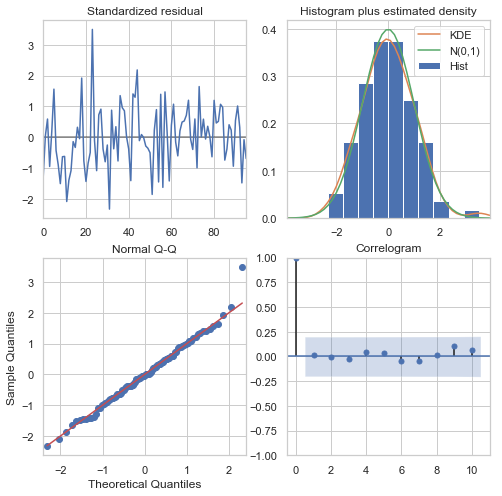

The Root Mean Squared Error of our forcast is 0.04
The root mean squared error of City: 1 of our forcast isvalue    0.334
dtype: float64% of mean housing price from 2019.


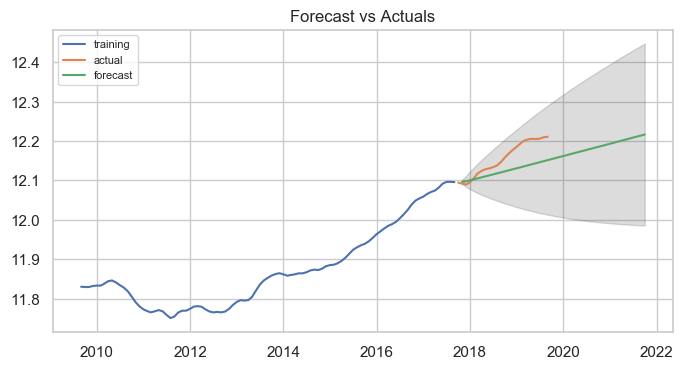

City:  2
ADF Statistic Residual: -2.787899
p-value: 0.060023


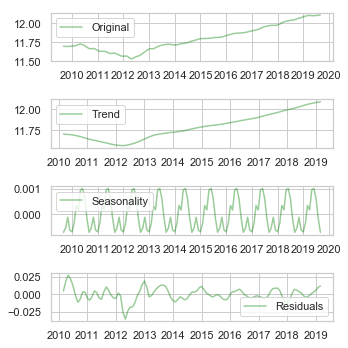

Fit ARIMA: order=(1, 2, 1); AIC=-718.155, BIC=-707.940, Fit time=0.131 seconds
Fit ARIMA: order=(0, 2, 0); AIC=-680.688, BIC=-675.580, Fit time=0.006 seconds
Fit ARIMA: order=(1, 2, 0); AIC=-682.977, BIC=-675.315, Fit time=0.039 seconds
Fit ARIMA: order=(0, 2, 1); AIC=-719.487, BIC=-711.825, Fit time=0.050 seconds
Fit ARIMA: order=(0, 2, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 2, 2); AIC=-731.107, BIC=-718.338, Fit time=0.157 seconds
Fit ARIMA: order=(2, 2, 2); AIC=-751.671, BIC=-736.348, Fit time=0.284 seconds
Fit ARIMA: order=(2, 2, 1); AIC=-749.844, BIC=-737.075, Fit time=0.189 seconds
Fit ARIMA: order=(2, 2, 3); AIC=-755.702, BIC=-737.825, Fit time=0.592 seconds
Fit ARIMA: order=(3, 2, 4); AIC=-753.633, BIC=-730.648, Fit time=1.684 seconds
Fit ARIMA: order=(1, 2, 3); AIC=-755.509, BIC=-740.186, Fit time=0.365 seconds
Fit ARIMA: order=(3, 2, 3); AIC=-756.057, BIC=-735.626, Fit time=1.259 seconds
Fit ARIMA: order=(3, 2, 2); AIC=-755.060, BIC=-737.183, Fit time

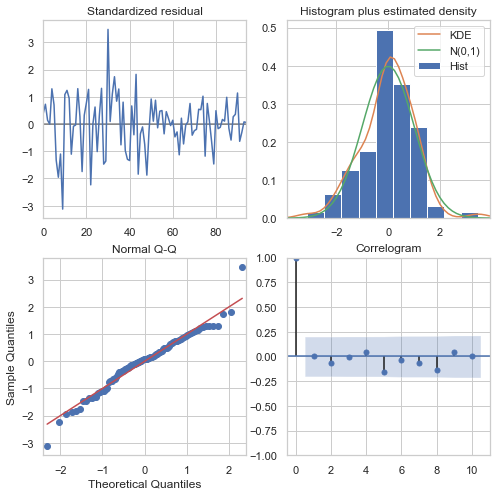

The Root Mean Squared Error of our forcast is 0.07
The root mean squared error of City: 2 of our forcast isvalue    0.569
dtype: float64% of mean housing price from 2019.


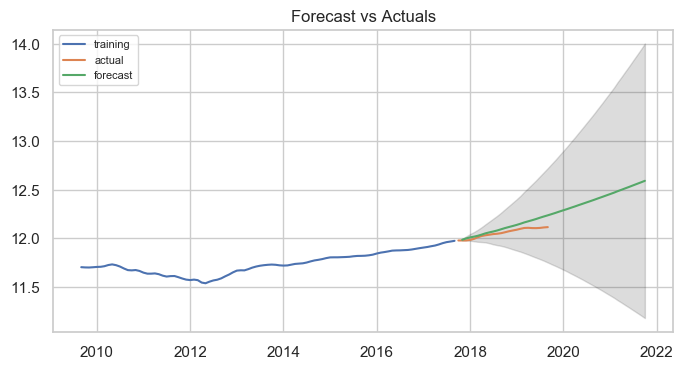

AIC list: [-818.5554251302949, -855.1376778573863, -764.9147392575182]
RMSE list: [value    0.681507
dtype: float64, value    0.334159
dtype: float64, value    0.568593
dtype: float64]


(None, None)

In [377]:
ARIMA_modeling(log_cities)

# SARIMA Modeling

**SARIMAX Rule of Thumb**

When using SARIMAX you will need a minimum number of observations in order to take care of the following:

- To estimate seasonal effects, you should have at least one complete cycle of data (e.g. if you want to estimate a quarterly seasonal effect, you should have at least one year (four quarters) of data).
- When the model specifies differencing, you essentially lose the first d + D*s datapoints (because they don't have a prior set of obs that can be used to compute the difference)
- Estimating moving average parameters can be difficult since the error terms are unobserved, and so require more data.

A good rule of thumb to follow for a SARIMAX (p,d,q)x(P,D,Q,s) model:

- d + D*s + max(3*q + 1, 3*Q*s + 1, p, P*s) + 1 observations

Source: https://github.com/statsmodels/statsmodels/issues/4465

**SARIMAX for cities that only required differencing**

In [390]:
#Step 1: determine the optimal level for ARIMA and SARIMA
#Create an empty list to contain the optimal order (p,d,q) and seasonal order (p,d,q,12)
#Use optimise_sarimax function
ARIMA_optimal_order = []
SARIMA_optimal_order = []
for i in range(0,len(Diff_cities)):
    
    #optmise_sarimax is a user defined function that finds the 
    #optimal order based on lowest AIC
    dfoptimal = optimise_sarimax(Diff_cities[i], 3,3,3)
    order = dfoptimal['pdq'][0]
    seasonal_order = dfoptimal['pdqs'][0]
    
    ARIMA_optimal_order.append(order)
    SARIMA_optimal_order .append(seasonal_order)

City: [0]
Non-seasonal parameters (p,d,q): (2, 2, 0)
Seasonal parameters and periodicity (P,D,Q,s): (2, 2, 0, 12)
AIC: 799.5125274147368
BIC: 808.5458398635884
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5152      0.146      3.538      0.000       0.230       0.801
ar.L2         -0.5565      0.142     -3.922      0.000      -0.835      -0.278
ar.S.L12      -1.0394      0.165     -6.305      0.000      -1.363      -0.716
ar.S.L24      -0.2199      0.166     -1.323      0.186      -0.546       0.106
sigma2      2.438e+06   6.41e+05      3.807      0.000    1.18e+06    3.69e+06


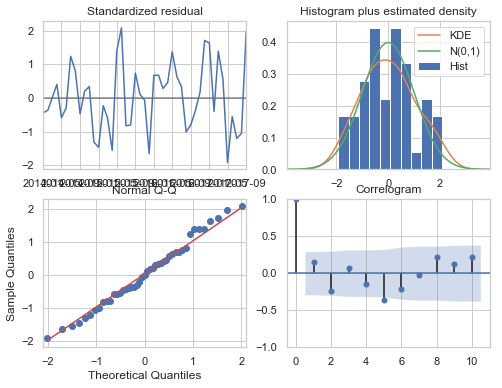



The Root Mean Squared Error of our forecasts is 82397.12
The root mean squared error of City: 0 of our forcast is value    92.264
dtype: float64% of mean housing price from 2017.


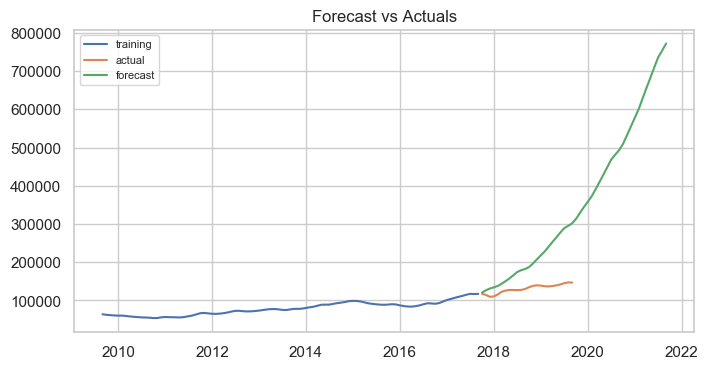

City: [1]
Non-seasonal parameters (p,d,q): (2, 2, 1)
Seasonal parameters and periodicity (P,D,Q,s): (2, 2, 1, 12)
AIC: 766.1004267963566
BIC: 778.7470642247488
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2444      0.149      1.638      0.101      -0.048       0.537
ar.L2         -0.6136      0.139     -4.421      0.000      -0.886      -0.342
ma.L1          0.1234      0.112      1.105      0.269      -0.096       0.342
ar.S.L12      -1.1611      0.158     -7.358      0.000      -1.470      -0.852
ar.S.L24      -0.4908      0.126     -3.909      0.000      -0.737      -0.245
ma.S.L12       0.0584      0.135      0.431      0.666      -0.207       0.324
sigma2      1.058e+06   2.84e+05      3.727      0.000    5.01e+05    1.61e+06


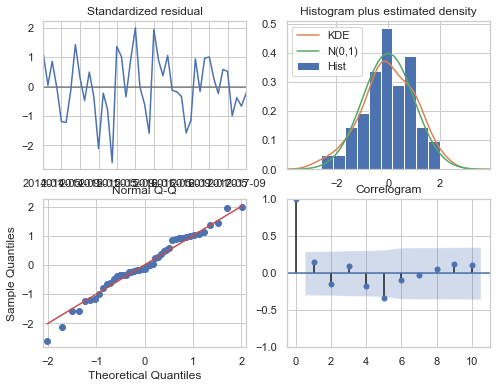



The Root Mean Squared Error of our forecasts is 11399.24
The root mean squared error of City: 1 of our forcast is value    10.604
dtype: float64% of mean housing price from 2017.


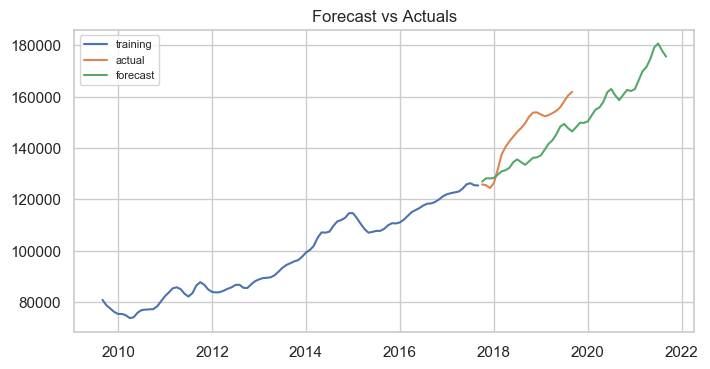

City: [2]
Non-seasonal parameters (p,d,q): (2, 2, 0)
Seasonal parameters and periodicity (P,D,Q,s): (2, 2, 0, 12)
AIC: 816.0726004798177
BIC: 825.1059129286692
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7197      0.154      4.682      0.000       0.418       1.021
ar.L2         -0.7198      0.127     -5.687      0.000      -0.968      -0.472
ar.S.L12      -1.1209      0.145     -7.752      0.000      -1.404      -0.837
ar.S.L24      -0.4533      0.155     -2.925      0.003      -0.757      -0.150
sigma2      3.523e+06   8.47e+05      4.157      0.000    1.86e+06    5.18e+06


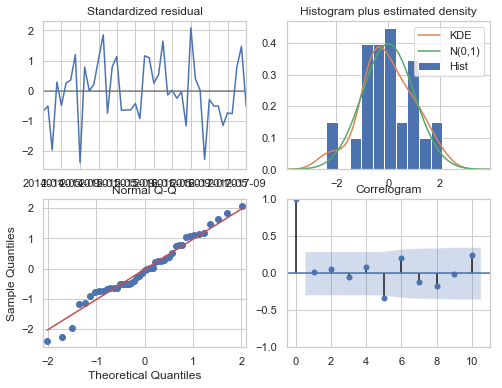



The Root Mean Squared Error of our forecasts is 32183.19
The root mean squared error of City: 2 of our forcast is value    23.437
dtype: float64% of mean housing price from 2017.


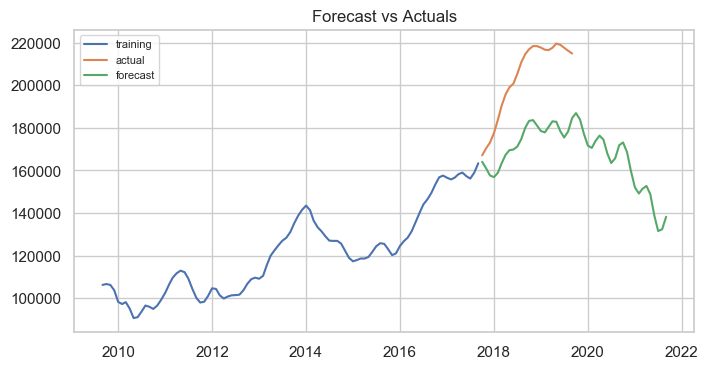

City: [3]
Non-seasonal parameters (p,d,q): (2, 2, 1)
Seasonal parameters and periodicity (P,D,Q,s): (2, 2, 1, 12)
AIC: 713.7942691461586
BIC: 726.4409065745508
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9364      0.125      7.500      0.000       0.692       1.181
ar.L2         -0.7252      0.103     -7.036      0.000      -0.927      -0.523
ma.L1         -0.2337      0.175     -1.335      0.182      -0.577       0.110
ar.S.L12      -0.8962      0.100     -8.979      0.000      -1.092      -0.701
ar.S.L24      -0.4824      0.089     -5.393      0.000      -0.658      -0.307
ma.S.L12      -0.0976      0.068     -1.432      0.152      -0.231       0.036
sigma2      3.326e+05   9.69e+04      3.434      0.001    1.43e+05    5.23e+05


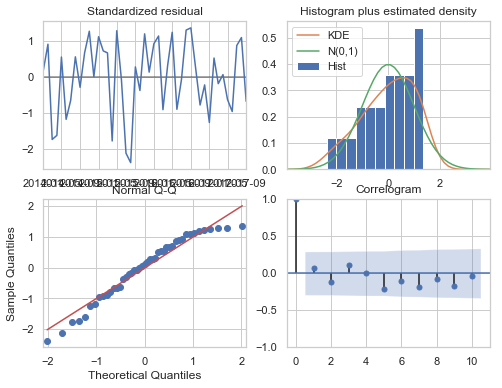



The Root Mean Squared Error of our forecasts is 13694.67
The root mean squared error of City: 3 of our forcast is value    11.66
dtype: float64% of mean housing price from 2017.


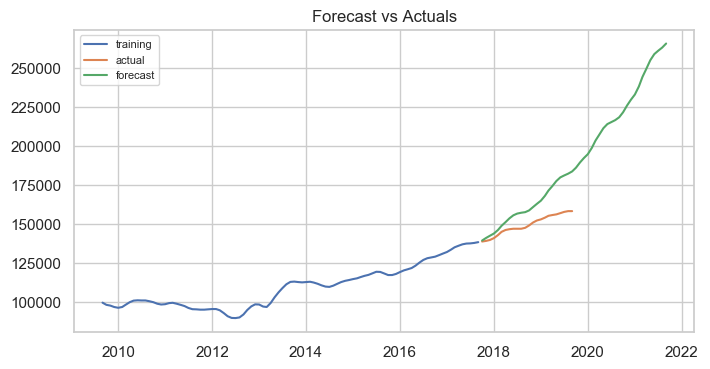

City: [4]
Non-seasonal parameters (p,d,q): (2, 2, 0)
Seasonal parameters and periodicity (P,D,Q,s): (2, 2, 0, 12)
AIC: 722.3086971274148
BIC: 731.3420095762664
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5911      0.123      4.793      0.000       0.349       0.833
ar.L2         -0.6972      0.114     -6.122      0.000      -0.920      -0.474
ar.S.L12      -0.8872      0.118     -7.539      0.000      -1.118      -0.657
ar.S.L24      -0.6779      0.156     -4.357      0.000      -0.983      -0.373
sigma2      4.385e+05   9.99e+04      4.390      0.000    2.43e+05    6.34e+05


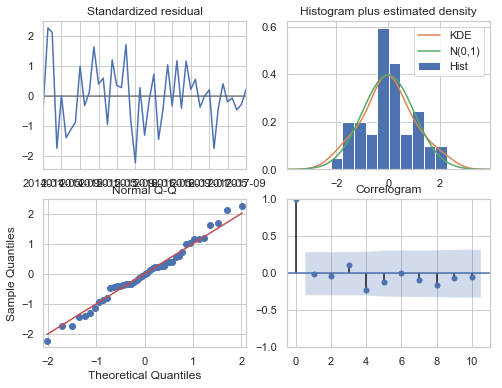



The Root Mean Squared Error of our forecasts is 6783.98
The root mean squared error of City: 4 of our forcast is value    4.777
dtype: float64% of mean housing price from 2017.


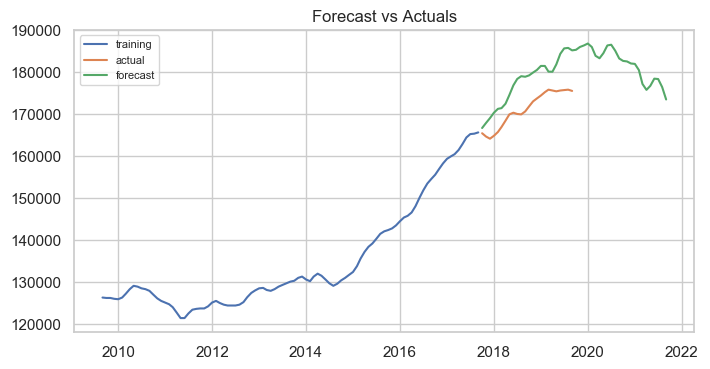

AIC list: [799.5125274147368, 766.1004267963566, 816.0726004798177, 713.7942691461586, 722.3086971274148]
RMSE list: [value    92.264035
dtype: float64, value    10.603861
dtype: float64, value    23.437226
dtype: float64, value    11.659874
dtype: float64, value    4.777172
dtype: float64]


(None, None)

In [391]:
SARIMA_modeling(Diff_cities, ARIMA_optimal_order, SARIMA_optimal_order)

**SARIMAX for cities that required log transform**

In [392]:
#Step 1: determine the optimal level for ARIMA and SARIMA
#Create an empty list to contain the optimal order (p,d,q) and seasonal order (p,d,q,12)
#Use optimise_sarimax function
ARIMA_optimal_order2 = []
SARIMA_optimal_order2 = []
for i in range(0,len(log_cities)):
    
    #optmise_sarimax is a user defined function that finds the 
    #optimal order based on lowest AIC
    dfoptimal2 = optimise_sarimax(log_cities[i], 3,3,3)
    order2 = dfoptimal2['pdq'][0]
    seasonal_order2 = dfoptimal2['pdqs'][0]
    
    ARIMA_optimal_order2.append(order2)
    SARIMA_optimal_order2 .append(seasonal_order2)

City: [0]
Non-seasonal parameters (p,d,q): (1, 1, 1)
Seasonal parameters and periodicity (P,D,Q,s): (1, 1, 1, 12)
AIC: -577.8643204426749
BIC: -566.6218442324281
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6906      0.089      7.789      0.000       0.517       0.864
ma.L1          0.8012      0.074     10.762      0.000       0.655       0.947
ar.S.L12      -0.3655      0.091     -3.999      0.000      -0.545      -0.186
ma.S.L12      -0.4933      0.209     -2.366      0.018      -0.902      -0.085
sigma2      1.214e-05   2.03e-06      5.994      0.000    8.17e-06    1.61e-05


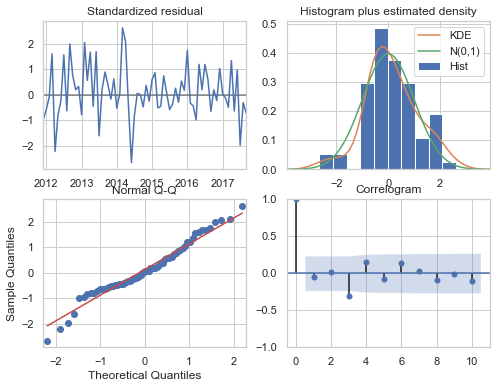



The Root Mean Squared Error of our forecasts is 0.02
The root mean squared error of City: 0 of our forcast is value    0.145
dtype: float64% of mean housing price from 2017.


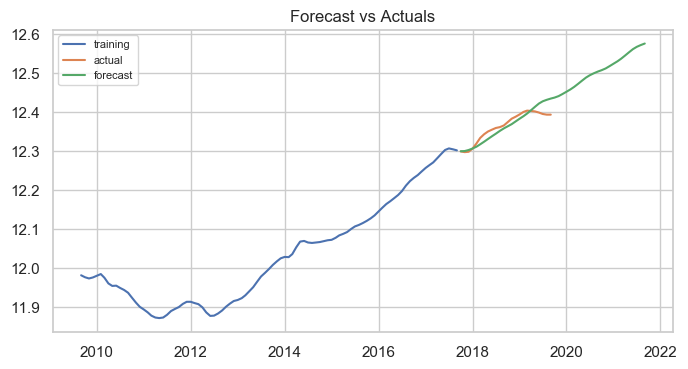

City: [1]
Non-seasonal parameters (p,d,q): (2, 0, 2)
Seasonal parameters and periodicity (P,D,Q,s): (2, 0, 2, 12)
AIC: -532.2402302252015
BIC: -512.0037730467573
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6366      0.011    144.439      0.000       1.614       1.659
ar.L2         -0.6365      0.012    -54.996      0.000      -0.659      -0.614
ma.L1          0.7835      0.000   1962.783      0.000       0.783       0.784
ma.L2          0.0837      0.000    567.426      0.000       0.083       0.084
ar.S.L12       1.2543   2.34e-05   5.37e+04      0.000       1.254       1.254
ar.S.L24      -0.2483      0.000   -763.564      0.000      -0.249      -0.248
ma.S.L12     -48.5204   8.77e-07  -5.53e+07      0.000     -48.520     -48.520
ma.S.L24       5.8868   7.17e-06   8.22e+05      0.000       5.887       5.887
sigma2      8.558e-09   1.15e-09      7.422     

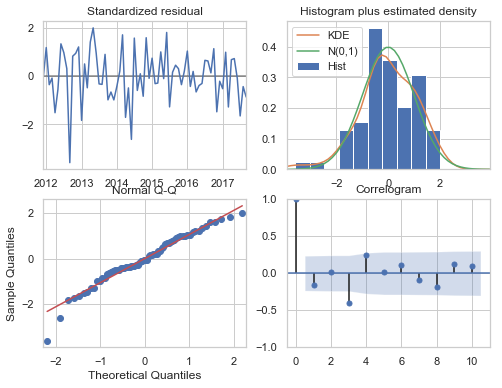



The Root Mean Squared Error of our forecasts is 0.03
The root mean squared error of City: 1 of our forcast is value    0.261
dtype: float64% of mean housing price from 2017.


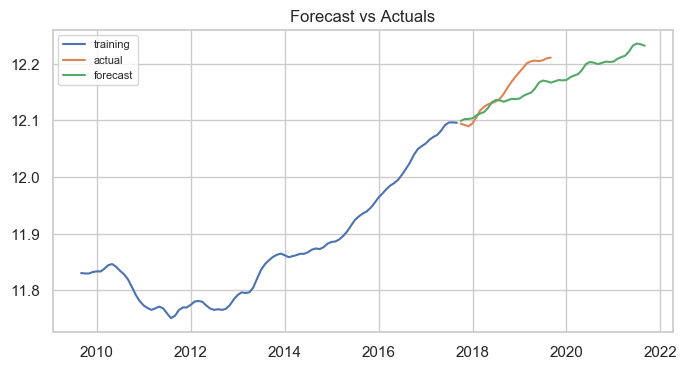

City: [2]
Non-seasonal parameters (p,d,q): (1, 0, 1)
Seasonal parameters and periodicity (P,D,Q,s): (1, 0, 1, 12)
AIC: -514.6785739403641
BIC: -502.58437090138113
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9870      0.032     31.233      0.000       0.925       1.049
ma.L1          0.9900      0.212      4.675      0.000       0.575       1.405
ar.S.L12       0.9952      0.030     33.185      0.000       0.936       1.054
ma.S.L12       2.4580      0.537      4.574      0.000       1.405       3.511
sigma2      1.632e-05   8.69e-06      1.879      0.060   -7.04e-07    3.33e-05


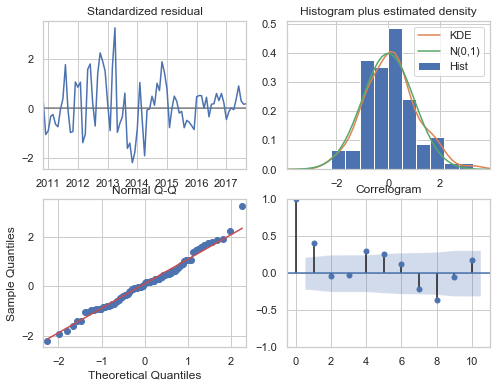



The Root Mean Squared Error of our forecasts is 0.01
The root mean squared error of City: 2 of our forcast is value    0.115
dtype: float64% of mean housing price from 2017.


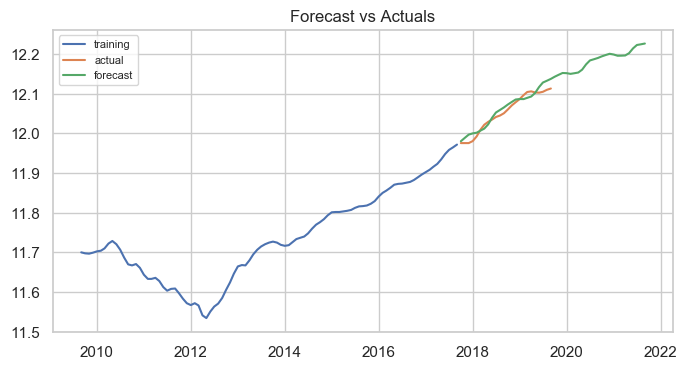

AIC list: [-577.8643204426749, -532.2402302252015, -514.6785739403641]
RMSE list: [value    0.145198
dtype: float64, value    0.261357
dtype: float64, value    0.115218
dtype: float64]


(None, None)

In [393]:
SARIMA_modeling(log_cities, ARIMA_optimal_order2, SARIMA_optimal_order2)

# Step 6: Interpreting Results